### Metabolic Flux Analysis

In [1]:
import math

import csv
from cmath import exp, log
import cobra
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar
from scipy.stats import norm
import random
import copy

In [2]:
Dry2Wet = 0.1

### 1. MODEL

In [3]:
class FBA:
    def __init__(self):
        # open the model
        self.model = cobra.io.read_sbml_model("iJTC6240_in_SBML.xml")

        # mmol_per_gDW_per_hr

        met_0429 = self.model.metabolites.get_by_id("met_0429") # CO2 cytosol
        met_0430 = self.model.metabolites.get_by_id("met_0430") # CO2 mitochondria
        met_0431 = self.model.metabolites.get_by_id("met_0431") # CO2 periplasm
        met_0432 = self.model.metabolites.get_by_id("met_0432") # CO2 peroxisome

        met_2737 = self.model.metabolites.get_by_id("met_2737") # squalene

        CO2_consumption = self.model.reactions.get_by_id('reac_1169')
        self.model.reactions.get_by_id('reac_1169').bounds = (0.8, 0.88) # photosynthesis
        self.model.reactions.get_by_id('reac_0443').bounds = (30, 39) # CO2 uptake
        # photosynthesis: 20 umol CO2 per m^2 per s
        # 20/1000*60*60*2/1700/(0.1) = 0.847
        # leaf avg: 2m^2 1700g
        # assume 10% dry weight

        # CO2 amount in the cell
        # avg: 210 umol CO2 per mol air

        met_1352 = self.model.metabolites.get_by_id("met_1352")
        met_0417 = self.model.metabolites.get_by_id("met_0417")
        met_0418 = self.model.metabolites.get_by_id("met_0418") # chlorogenic acid
        met_2715 = self.model.metabolites.get_by_id("met_2715") # shikimate
        met_0419 = self.model.metabolites.get_by_id("met_0419") # caffeoyl shikimate
        met_2888 = self.model.metabolites.get_by_id("met_2888") # H2O
        met_2632 = self.model.metabolites.get_by_id("met_2632") # quinate
        met_2386 = self.model.metabolites.get_by_id("met_2386") # NADPH
        met_2591 = self.model.metabolites.get_by_id("met_2591") # H+
        met_2382 = self.model.metabolites.get_by_id("met_2382") # NADP+
        met_2378 = self.model.metabolites.get_by_id("met_2378") # NADH
        met_2372 = self.model.metabolites.get_by_id("met_2372") # NAD+
        met_1838 = self.model.metabolites.get_by_id("met_1838") # 3-dehydroquinate
        met_0110 = self.model.metabolites.get_by_id("met_0110") # 3-dehydroshikimate
        met_0079 = self.model.metabolites.get_by_id("met_0079") # 2-O-caffeoylglucarate
        met_1795 = self.model.metabolites.get_by_id("met_1795") # glucarate
        met_2521 = self.model.metabolites.get_by_id("met_2521") # PEP
        met_1953 = self.model.metabolites.get_by_id("met_1953") # E4P
        met_2544 = self.model.metabolites.get_by_id("met_2544") # Pi
        met_0112 = self.model.metabolites.get_by_id("met_0112") # DAHP
        met_0512 = self.model.metabolites.get_by_id('met_0512') # CoA
        met_0367 = self.model.metabolites.get_by_id('met_0367') # ATP
        met_0344 = self.model.metabolites.get_by_id('met_0344') # AMP
        met_2566 = self.model.metabolites.get_by_id('met_2566') # diphosphate
        met_0339 = self.model.metabolites.get_by_id('met_0339')
        met_2238 = self.model.metabolites.get_by_id('met_2238') # L-dopa
        
        # self.model.reactions.get_by_id('reac_0223').bounds = (0, 4)
        # self.model.reactions.get_by_id('reac_2010').bounds = (0.01, 0.03)
        # self.model.reactions.get_by_id('reac_0066').bounds = (0.01, 0.03)
        self.model.reactions.get_by_id('reac_1317').bounds = (0, 0.5)
        self.model.reactions.get_by_id('reac_2013').bounds = (-1000, 1000)


        # restrict = self.model.problem.Constraint(
        # self.model.reactions.reac_1317.flux_expression - self.model.reactions.reac_0223.flux_expression,
        # lb=-4,
        # ub=4)
        # self.model.add_cons_vars(restrict)

        # 4CL
        R_4CL = cobra.Reaction('4CL')
        R_4CL.add_metabolites({met_1352: -1, met_0367: -1, met_0512: -1,
                               met_0417: 1, met_0344: 1, met_2566: 1})
        R_4CL.bounds = (0, 1000)
        self.model.add_reactions([R_4CL])

        # CSE
        R_CSE = cobra.Reaction('CSE')
        R_CSE.add_metabolites({met_0419: -1, met_2888: -1, met_2715: 1, met_1352: 1})
        R_CSE.bounds = (0, 1000)
        self.model.add_reactions([R_CSE])
        
        # quinate dehydrogenase
        R_quinate_dehydrogenase1 = cobra.Reaction('quinate_dehydrogenase1')
        R_quinate_dehydrogenase1.add_metabolites({met_2632: -1, met_2382: -1, met_1838: 1, met_2386: 1, met_2591: 1})
        R_quinate_dehydrogenase1.bounds = (-1000, 1000)
        R_quinate_dehydrogenase2 = cobra.Reaction('quinate_dehydrogenase2')
        R_quinate_dehydrogenase2.add_metabolites({met_2632: -1, met_2372: -1, met_1838: 1, met_2378: 1, met_2591: 1})
        R_quinate_dehydrogenase2.bounds = (-1000, 1000)
        self.model.add_reactions([R_quinate_dehydrogenase1, R_quinate_dehydrogenase2])

        # dehydroquinate dehydratase
        R_dehydroquinate_dehydratase = cobra.Reaction('dehydroquinate_dehydratase')
        R_dehydroquinate_dehydratase.add_metabolites({met_1838: -1, met_0110: 1, met_2888: 1})
        R_dehydroquinate_dehydratase.bounds = (-1000, 1000)
        self.model.add_reactions([R_dehydroquinate_dehydratase])

        # 2-O-caffeoylglucarate tx
        R_2_O_caffeoylglucarate_tx = cobra.Reaction('2_O_caffeoylglucarate_tx')
        R_2_O_caffeoylglucarate_tx.add_metabolites({met_0079: -1})
        R_2_O_caffeoylglucarate_tx.bounds = (-1000, 1000)
        self.model.add_reactions([R_2_O_caffeoylglucarate_tx])

        # glucarate synthesis
        R_glucarate_synthesis = cobra.Reaction('glucarate_synthesis')
        R_glucarate_synthesis.add_metabolites({met_1795: 1})
        R_glucarate_synthesis.bounds = (-1000, 1000)
        self.model.add_reactions([R_glucarate_synthesis])

        # chlorogenic acid proc
        chlorogenic_acid_proc = cobra.Reaction('chlorogenic_acid_proc')
        chlorogenic_acid_proc.add_metabolites({met_0418: -1})
        chlorogenic_acid_proc.bounds = (0, 1000)
        self.model.add_reactions([chlorogenic_acid_proc])
        # chlorogenic acid:
        # 6 mg/gDW
        # 354.31 g/mol
        # 6/354.31 = 1.69e-2 mmol/gDW
        # 8 weeks
        # 1.69e-2/8/7/24 = 1.6e-5 mmol/gDW/hr

        '''
        squalene_proc = cobra.Reaction('squalene_proc')
        squalene_proc.add_metabolites({met_2737: -1})
        model.add_reactions([squalene_proc])

        # squalene: 6 ug/gFW
        # 410 g/mol
        # 10% DW
        # 6/410/1000*(10) = 1.46e-3 mmol/gDW
        '''


        '''
        Caffeoylmalic_acid
        '''      
        # TAL
        R_TAL = cobra.Reaction('R_TAL')
        R_TAL.add_metabolites({met_2238: -1, met_1352: 1, met_0339: 1})
        R_TAL.bounds = (-1000, 2.2)
        self.model.add_reactions([R_TAL])
        

        '''
        Resveratol
        '''
        met_0512 = self.model.metabolites.get_by_id('met_0512') # coenzymeA
        met_2888 = self.model.metabolites.get_by_id('met_2888') # H2O
        met_1953 = self.model.metabolites.get_by_id("met_1953") # D-erythrose4-phosphate
        met_2521 = self.model.metabolites.get_by_id("met_2521") # phosphoenolpyruvate
        met_0112 = self.model.metabolites.get_by_id("met_0112") # 3-deoxy-D-arabino-heptulosonate7-phosphate
        met_2544 = self.model.metabolites.get_by_id("met_2544") # phosphate
        met_2386 = self.model.metabolites.get_by_id("met_2386") # NADPH
        met_2382 = self.model.metabolites.get_by_id("met_2382") # NADP+
        met_0367 = self.model.metabolites.get_by_id('met_0367') # ATP

        # DAHP synthase
        DAHP_synthase = cobra.Reaction('DAHP_synthase')
        DAHP_synthase.add_metabolites({met_1953:-1, met_2521:-1, met_2888:-1, met_0112:1, met_2544:1})
        DAHP_synthase.bounds = (0,1000)
        self.model.add_reactions([DAHP_synthase])
        
        '''
        Crocin
        '''
        met_2556 = self.model.metabolites.get_by_id('met_2556')
        met_0650 = self.model.metabolites.get_by_id('met_0650')
        met_0747 = self.model.metabolites.get_by_id('met_0747')
        met_2552 = self.model.metabolites.get_by_id('met_2552') 
        met_2591 = self.model.metabolites.get_by_id("met_2591") # H+
        met_2378 = self.model.metabolites.get_by_id("met_2378") # NADH
        met_2372 = self.model.metabolites.get_by_id("met_2372") # NAD+
        met_2888 = self.model.metabolites.get_by_id("met_2888") # H2O
        met_1461 = self.model.metabolites.get_by_id("met_1461") 
        met_1462 = self.model.metabolites.get_by_id("met_1462") 
        met_1464 = self.model.metabolites.get_by_id("met_1464") 
        met_1465 = self.model.metabolites.get_by_id("met_1465") 
        met_2554 = self.model.metabolites.get_by_id("met_2554") 
        met_1120 = self.model.metabolites.get_by_id("met_1120") 
        met_0699 = self.model.metabolites.get_by_id("met_0699") 
        met_1675 = self.model.metabolites.get_by_id("met_1675") 
        met_0635 = self.model.metabolites.get_by_id("met_0635") 
        met_1686 = self.model.metabolites.get_by_id("met_1686") 
        met_2838 = self.model.metabolites.get_by_id("met_2838") 
        met_2462 = self.model.metabolites.get_by_id("met_2462") 
        met_2657 = self.model.metabolites.get_by_id("met_2657") 
       

        R_cis_phytoene_desaturase = cobra.Reaction('R_cis_phytoene_desaturase')
        R_cis_phytoene_desaturase.add_metabolites({met_2556:-1, met_0650:-1, met_0747:1, met_2552:1})
        R_cis_phytoene_desaturase.bounds = (0, 1000)

        R_1 = cobra.Reaction('R_1')
        R_1.add_metabolites({met_2554:-1, met_0699:1})
        R_1.bounds = (-1000, 1000)

        R_2 = cobra.Reaction('R_2')
        R_2.add_metabolites({met_1464:-1, met_1465:1})
        R_2.bounds = (-1000, 1000)

        R_3 = cobra.Reaction('R_3')
        R_3.add_metabolites({met_1462:-1, met_1461:1})
        R_3.bounds = (-1000, 1000)

        R_4 = cobra.Reaction('R_4')
        R_4.add_metabolites({met_2462:-1, met_2657:1})
        R_4.bounds = (-1000, 1000)

        R_5 = cobra.Reaction('R_5')
        R_5.add_metabolites({met_1120:-1})
        R_5.bounds = (-1000, 1000)

        R_6 = cobra.Reaction('R_6')
        R_6.add_metabolites({met_2556:-1, met_2552:1})
        R_6.bounds = (-1000, 1000)

        R_7 = cobra.Reaction('R_7')
        R_7.add_metabolites({met_1675:-1, met_0635:1})
        R_7.bounds = (-1000, 1000)

        R_8 = cobra.Reaction('R_8')
        R_8.add_metabolites({met_1686:-1, met_2838:1})
        R_8.bounds = (-1000, 1000)

        self.model.add_reactions([R_1, R_2, R_3, R_4, R_5, R_6, R_7, R_8, R_cis_phytoene_desaturase])

        self.OBJ = self.Calc_biomass() + 0.6633335 * chlorogenic_acid_proc.flux_expression
        # self.OBJ = self.Calc_biomass() + 0.66333349 * chlorogenic_acid_proc.flux_expression

    def Calc_biomass(self):
        # Cell wall
        self.model.reactions.get_by_id('reac_0425').bounds = (0, 1.80) # CELLULOSE
        Cell_wall = self.model.reactions.reac_0425.flux_expression
        # Carbohydrate
        self.model.reactions.get_by_id('reac_0641').bounds = (0.0060, 0.0070) # Glucose
        self.model.reactions.get_by_id('reac_0604').bounds = (0.002, 0.006) # Fructose
        # self.model.reactions.get_by_id('reac_2763').bounds = (0.01, 0.03) # Sucrose
        self.model.reactions.get_by_id('reac_2747').bounds = (0.10, 0.20) # Starch
        Carbohydrate = self.model.reactions.reac_0641.flux_expression +\
            self.model.reactions.reac_0604.flux_expression +\
            self.model.reactions.reac_2763.flux_expression +\
            self.model.reactions.reac_2747.flux_expression 
        # DNA
        self.model.reactions.get_by_id('reac_0483').bounds = (0.0025, 0.0035) # dATP
        self.model.reactions.get_by_id('reac_0488').bounds = (0.0015, 0.0025) # dCTP
        self.model.reactions.get_by_id('reac_0505').bounds = (0.0015, 0.0025) # dGTP
        self.model.reactions.get_by_id('reac_0546').bounds = (0.0025, 0.0035) # dTTP
        DNA = self.model.reactions.reac_0483.flux_expression +\
            self.model.reactions.reac_0488.flux_expression +\
            self.model.reactions.reac_0505.flux_expression +\
            self.model.reactions.reac_0546.flux_expression
        # RNA
        self.model.reactions.get_by_id('reac_0377').bounds = (0.0025, 0.0035) # ATP
        self.model.reactions.get_by_id('reac_0456').bounds = (0.0015, 0.0025) # CTP
        self.model.reactions.get_by_id('reac_2873').bounds = (0.0025, 0.0035) # UTP
        self.model.reactions.get_by_id('reac_0735').bounds = (0.0015, 0.0025) # GTP
        RNA = self.model.reactions.reac_0377.flux_expression +\
            self.model.reactions.reac_0456.flux_expression +\
            self.model.reactions.reac_2873.flux_expression +\
            self.model.reactions.reac_0735.flux_expression
        # Hemicellulose
        self.model.reactions.get_by_id('reac_0834').bounds = (0.33, 0.48) # Arabinose
        self.model.reactions.get_by_id('reac_0476').bounds = (0.33, 0.48) # Xylose
        self.model.reactions.get_by_id('reac_0893').bounds = (0.30, 0.42) # Mannose
        self.model.reactions.get_by_id('reac_0475').bounds = (0.30, 0.42) # Galactose
        self.model.reactions.get_by_id('reac_0620').bounds = (0.3, 0.4) # Glucuronate
        Hemicellulose = self.model.reactions.reac_0834.flux_expression +\
            self.model.reactions.reac_0476.flux_expression +\
            self.model.reactions.reac_0893.flux_expression +\
            self.model.reactions.reac_0475.flux_expression +\
            self.model.reactions.reac_0620.flux_expression
        # Lignin
        self.model.reactions.get_by_id('reac_0449').bounds = (0.10, 0.15) # Coumaryl alcohol
        self.model.reactions.get_by_id('reac_0448').bounds = (0, 0.12) # Coniferyl alcohol
        self.model.reactions.get_by_id('reac_2733').bounds = (0, 0.095) # Sinapyl alcohol
        Lignin = self.model.reactions.reac_0449.flux_expression +\
            self.model.reactions.reac_0448.flux_expression +\
            self.model.reactions.reac_2733.flux_expression
        # Lipid
        self.model.reactions.get_by_id('reac_0450').bounds = (0.055, 0.070) # eleostearate
        self.model.reactions.get_by_id('reac_0451').bounds = (0, 0.003) # palmitoleate
        self.model.reactions.get_by_id('reac_0854').bounds = (0.001, 0.003) # linoleate
        self.model.reactions.get_by_id('reac_0991').bounds = (0.001, 0.003) # oleate
        self.model.reactions.get_by_id('reac_1015').bounds = (0, 0.003) # palmitate
        self.model.reactions.get_by_id('reac_2750').bounds = (0.001, 0.003) # stearate
        Lipid = self.model.reactions.reac_0450.flux_expression +\
            self.model.reactions.reac_0451.flux_expression +\
            self.model.reactions.reac_0854.flux_expression +\
            self.model.reactions.reac_0991.flux_expression +\
            self.model.reactions.reac_1015.flux_expression +\
            self.model.reactions.reac_2750.flux_expression 
        # Protein
        self.model.reactions.get_by_id('reac_2826').bounds = (0.0002, 0.0004) # tryptophan
        self.model.reactions.get_by_id('reac_0864').bounds = (0.0005, 0.0007) # lysine
        self.model.reactions.get_by_id('reac_0762').bounds = (0.0004, 0.0006) # histidine
        self.model.reactions.get_by_id('reac_0346').bounds = (0.0003, 0.0005) # arginine
        self.model.reactions.get_by_id('reac_0835').bounds = (0.0015, 0.0025) # aspartate
        self.model.reactions.get_by_id('reac_2800').bounds = (0.0035, 0.0045) # threonine
        self.model.reactions.get_by_id('reac_2717').bounds = (0.018, 0.025) # serine
        self.model.reactions.get_by_id('reac_0648').bounds = (0.017, 0.023) # glutamate
        self.model.reactions.get_by_id('reac_1085').bounds = (0.0075, 0.0090) # proline
        self.model.reactions.get_by_id('reac_0698').bounds = (0.0045, 0.0054) # glycine
        self.model.reactions.get_by_id('reac_0833').bounds = (0.0043, 0.0052) # alanine
        self.model.reactions.get_by_id('reac_2876').bounds = (0.0010, 0.0015) # valine
        # self.model.reactions.get_by_id('reac_0900').bounds = (0.0001, 0.0003) # methionine
        self.model.reactions.get_by_id('reac_0798').bounds = (0.0005, 0.0007) # isoleucine
        self.model.reactions.get_by_id('reac_0845').bounds = (0.0008, 0.0010) # leucine
        self.model.reactions.get_by_id('reac_2833').bounds = (0.0002, 0.0004) # tyrosine
        self.model.reactions.get_by_id('reac_1037').bounds = (0.0012, 0.0015) # phenylalanine
        self.model.reactions.get_by_id('reac_0359').bounds = (0.0092, 0.0100) # asparagine
        self.model.reactions.get_by_id('reac_0645').bounds = (0.013, 0.016) # glutamine
        self.model.reactions.get_by_id('reac_0461').bounds = (0.0001, 0.0003) # cysteine
        Protein = self.model.reactions.reac_2826.flux_expression +\
            self.model.reactions.reac_0864.flux_expression +\
            self.model.reactions.reac_0762.flux_expression +\
            self.model.reactions.reac_0346.flux_expression +\
            self.model.reactions.reac_0835.flux_expression +\
            self.model.reactions.reac_2800.flux_expression +\
            self.model.reactions.reac_2717.flux_expression +\
            self.model.reactions.reac_0648.flux_expression +\
            self.model.reactions.reac_1085.flux_expression +\
            self.model.reactions.reac_0698.flux_expression +\
            self.model.reactions.reac_0833.flux_expression +\
            self.model.reactions.reac_2876.flux_expression +\
            self.model.reactions.reac_0900.flux_expression +\
            self.model.reactions.reac_0798.flux_expression +\
            self.model.reactions.reac_0845.flux_expression +\
            self.model.reactions.reac_2833.flux_expression +\
            self.model.reactions.reac_1037.flux_expression +\
            self.model.reactions.reac_0359.flux_expression +\
            self.model.reactions.reac_0645.flux_expression +\
            self.model.reactions.reac_0461.flux_expression

        BIOMASS = 1 * Cell_wall + 0.4975 * Carbohydrate +\
            0.5224 * DNA + 5.1009 * RNA + 1 * Hemicellulose +\
            1.0000 * Lignin + 1.6767 * Lipid + 10.2258 * Protein
        return BIOMASS

    def Print_sol(self):
        sol = self.proc()
        for rxn in self.model.reactions:
            if sol.fluxes[rxn.id] != 0:
                print(f"{rxn.id}: {sol.fluxes[rxn.id]}")

    def Print_met(self, sol, met):
        for reac in met.reactions:
            print(f"{reac.id}: {sol.fluxes[reac.id]}")

    def Find_name_reac(self, name):
        res = []
        for reac in self.model.reactions:
            if name in reac.name:
                res.append(reac)
        return res

    # def set_obj(self, param, obj_reac):
    #     # obj_coeff = [1 for _ in biomass]
    #     obj = sum(coef * reac.flux_expression for coef, reac in zip(param, obj_reac))
    #     self.model.objective = obj
    #     return obj

    def knock_out(self, para):
        # HQT
        if 'HQT' in para:
            self.model.reactions.get_by_id('reac_2013').lower_bound = -0.35
            self.model.reactions.get_by_id('reac_2010').bounds = (0, 0.6)

        # HCT
        if 'HCT' in para:
            # self.model.reactions.get_by_id('reac_2013').upper_bound = 1
            # self.model.reactions.get_by_id('reac_0066').bounds = (0, 0.6)
            # self.model.reactions.get_by_id('reac_2012').bounds = (-0.6, 0.6)

            # self.model.reactions.get_by_id('reac_2013').upper_bound = 0.3
            # self.model.reactions.get_by_id('reac_0066').bounds = (-0.2, 0.2)
            # self.model.reactions.get_by_id('reac_2012').bounds = (-0.2, 0.2)

            self.model.reactions.get_by_id('reac_2013').upper_bound = 0
            self.model.reactions.get_by_id('reac_0066').bounds = (-0.0001, 0.0001)
            self.model.reactions.get_by_id('reac_2012').bounds = (-0.0001, 0.0001)
            self.model.reactions.get_by_id('reac_2010').bounds = (0, 3)

        # C3'H
        if 'C3\'H' in para:
            self.model.reactions.get_by_id('reac_2009').bounds = (0, 0)
            self.model.reactions.get_by_id('reac_0017').bounds = (-0.0001, 0.0001)

        # 4CL
        if '4CL' in para:
            self.model.reactions.get_by_id('4CL').bounds = (0, 0)
            self.model.reactions.get_by_id('reac_0223').bounds = (0, 0)

    def proc(self, obj):
        # self.set_obj(param, obj)
        self.model.objective = self.OBJ
        if obj:
            self.model.objective += obj

        sol = self.model.optimize()
        # consistent_model = cobra.flux_analysis.fastcc(self.model)
        # sol = consistent_model.optimize()
        return sol

    def check_balance(self, obj):
        sol = self.proc(obj)
        not_balanced = []
        for met in self.model.metabolites:
            S = 0
            for reac in met.reactions:
                coe = reac.metabolites[met]
                S += coe * sol.fluxes[reac.id]
            if abs(S) > 1e-9:
                not_balanced.append((met.id, S))
        if len(not_balanced):
            print('not balanced: \n' + '\n'.join(f'{met}: {num}' for met, num in not_balanced) + '\nend')
        else:
            print('balanced')

    # def deep_copy(self):
    #     return copy.deepcopy(self)

def Print_res(model, res, met=None, obj=None):
    sol = model.proc(obj)
    model.check_balance(obj)
    print(sol.objective_value)
    print('photosynthesis', sol.fluxes['reac_1169'])
    print('CO2: ', sol.fluxes['reac_0443'], '\n')
    if met:
        model.Print_met(sol, model.model.metabolites.get_by_id(met))
        print()
    print(res + ': ', sol.fluxes[res])
    return sol.fluxes[res]

result = {}

### 2. FBA

#### 2.1 Chlorogenic Acid Analysis in original models

In [4]:
fba_model = FBA()
fba_model.knock_out([])
result['control'] = Print_res(fba_model, 'chlorogenic_acid_proc', 'met_2484')

'' is not a valid SBML 'SId'.


balanced
1.8145517371425586
photosynthesis 0.88
CO2:  30.0 

reac_1314: 0.15
reac_1798: 0.0
reac_0223: 5.562855343511451
reac_1383: 0.0
reac_2384: 0.0
reac_0954: 0.0
reac_2258: 0.0
reac_2266: 0.0
reac_2359: 0.0
reac_1340: 0.0
reac_2030: 0.0
reac_2010: 5.412855343511451
reac_2259: 0.0
reac_0066: 0.0
reac_1796: 0.0
reac_1561: 0.0
reac_2390: 0.0
reac_2532: 0.0

chlorogenic_acid_proc:  5.412855343511451


In [5]:
fba_model = FBA()
fba_model.knock_out(['HCT'])
result['HCT'] = Print_res(fba_model, 'chlorogenic_acid_proc')

'' is not a valid SBML 'SId'.


balanced
1.8145514397082543
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  3.6282495112782147


In [6]:
fba_model = FBA()
fba_model.knock_out(['HQT'])
result['HQT'] = Print_res(fba_model, 'chlorogenic_acid_proc')

'' is not a valid SBML 'SId'.


balanced
1.8145509933333335
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  0.95


In [7]:
fba_model = FBA()
fba_model.knock_out(['C3\'H'])
result['C3\'H'] = Print_res(fba_model, 'chlorogenic_acid_proc','met_1352')

'' is not a valid SBML 'SId'.


balanced
1.8145512850166663
photosynthesis 0.8
CO2:  30.0 

reac_1317: 0.5
4CL: 2.7
CSE: 0.0
R_TAL: 2.2
reac_1318: 0.0

chlorogenic_acid_proc:  2.7001000000000004


In [8]:
fba_model = FBA()
fba_model.knock_out(['HCT', 'C3\'H'])
result['HCT+C3\'H'] = Print_res(fba_model, 'chlorogenic_acid_proc')

'' is not a valid SBML 'SId'.


balanced
1.8145512498767593
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  2.4892605490049857


In [9]:
fba_model = FBA()
fba_model.knock_out(['HQT', 'HCT'])
result['HQT+HCT'] = Print_res(fba_model, 'chlorogenic_acid_proc')

'' is not a valid SBML 'SId'.


balanced
1.8145513933333357
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  3.35


In [10]:
fba_model = FBA()
fba_model.knock_out(['HQT', 'C3\'H'])
result['HQT+C3\'H'] = Print_res(fba_model, 'chlorogenic_acid_proc')

'' is not a valid SBML 'SId'.


balanced
1.8145508933500003
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  0.35009999999999997


{'control': 5.412855343511451, 'HCT': 3.6282495112782147, 'HQT': 0.95, "C3'H": 2.7001000000000004, "HCT+C3'H": 2.4892605490049857, 'HQT+HCT': 3.35, "HQT+C3'H": 0.35009999999999997}


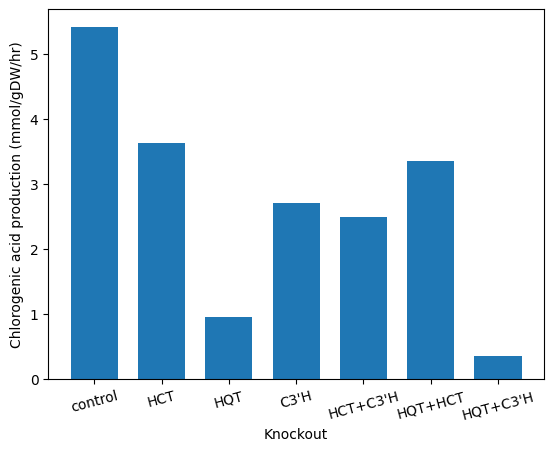

In [11]:
print(result)
plt.bar(result.keys(), result.values(), width=0.7)
plt.xlabel('Knockout')
plt.ylabel('Chlorogenic acid production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)
plt.show()

#### 2.2 Analysis in Caffeoylmalic Acid Model

In [12]:
# Caffeoylmalic acid
def Caffeoylmalic_acid_model_copy(): # must be called every time
    model = FBA()

    Caffeoylmalic_acid = cobra.Metabolite('Caffeoylmalic_acid')
    met_0512 = model.model.metabolites.get_by_id('met_0512') # CoA
    met_0417 = model.model.metabolites.get_by_id('met_0417')
    met_2298 = model.model.metabolites.get_by_id('met_2298')

    # HCT_M
    R_HCT_M1 = cobra.Reaction('HCT_M1')
    R_HCT_M1.add_metabolites({met_0417: -1, met_2298: -1, Caffeoylmalic_acid: 1, met_0512: 1})
    R_HCT_M1.bounds = (-1000, 1000)

    # Caffeoylmalic acid proc
    Caffeoylmalic_acid_proc = cobra.Reaction('Caffeoylmalic_acid_proc')
    Caffeoylmalic_acid_proc.add_metabolites({Caffeoylmalic_acid: -1})
    Caffeoylmalic_acid_proc.bounds = (0, 1000)

    model.model.add_reactions([R_HCT_M1, Caffeoylmalic_acid_proc])
    return model

# Caffeoylmalic_acid_coef = 0.53895853355
# Caffeoylmalic_acid_coef = 0.5389585
# Caffeoylmalic_acid_coef = 0.538958502
Caffeoylmalic_acid_coef = 0.538958542
# Caffeoylmalic_acid_coef = 0.538958533

Caff_model_control = Caffeoylmalic_acid_model_copy()

Caff_model_control.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (5.24, 5.4)

result_chlorogenic_acid = {}
result_caffeoylmalic_acid = {}
Caff_model_control.knock_out([])
result_chlorogenic_acid['control'] = Print_res(Caff_model_control, 'chlorogenic_acid_proc', 'met_0418', obj=Caffeoylmalic_acid_coef * Caff_model_control.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['control'] = Print_res(Caff_model_control, 'Caffeoylmalic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_control.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145519413745403
photosynthesis 0.88
CO2:  30.0 

reac_0074: 0.0
reac_2013: -1.0831891291527285
reac_0017: 4.156810870847272
chlorogenic_acid_proc: 5.24

chlorogenic_acid_proc:  5.24
balanced
1.8145519413745403
photosynthesis 0.88
CO2:  30.0 

Caffeoylmalic_acid_proc:  1.1168108708472717


In [13]:
Caff_model_HCT = Caffeoylmalic_acid_model_copy()

# Caff_model_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (1, 5.4)
Caff_model_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.5, 5.4)
Caff_model_HCT.model.reactions.get_by_id('reac_2816').bounds = (0.01, 0.2)

Caff_model_HCT.knock_out(['HCT'])
result_chlorogenic_acid['HCT'] = Print_res(Caff_model_HCT, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HCT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['HCT'] = Print_res(Caff_model_HCT, 'Caffeoylmalic_acid_proc','met_0418', obj=Caffeoylmalic_acid_coef * Caff_model_HCT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145518774208644
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  3.5
balanced
1.8145518774208644
photosynthesis 0.88
CO2:  30.0 

reac_0017: 3.0
reac_0074: 0.0
reac_2013: -0.5
chlorogenic_acid_proc: 3.5

Caffeoylmalic_acid_proc:  2.2001000000000004


In [14]:
Caff_model_HQT = Caffeoylmalic_acid_model_copy()

Caff_model_HQT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (0.95, 5.4)
Caff_model_HQT.model.reactions.get_by_id('reac_2013').bounds = (13.5, 1000)
Caff_model_HQT.model.reactions.get_by_id('reac_2816').bounds = (1.36, 6.93)
# Caff_model_HQT.model.reactions.get_by_id('reac_2816').bounds = (0, 1.99)

Caff_model_HQT.knock_out(['HQT'])
result_chlorogenic_acid['HQT'] = Print_res(Caff_model_HQT, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['HQT'] = Print_res(Caff_model_HQT, 'Caffeoylmalic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145517937359879
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  0.95
balanced
1.8145517937359879
photosynthesis 0.8
CO2:  30.0 

Caffeoylmalic_acid_proc:  3.8357954724555694


In [15]:
Caff_model_C3H = Caffeoylmalic_acid_model_copy()

Caff_model_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (2.4, 5.4)


Caff_model_C3H.knock_out(['C3\'H'])
result_chlorogenic_acid['C3\'H'] = Print_res(Caff_model_C3H, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['C3\'H'] = Print_res(Caff_model_C3H, 'Caffeoylmalic_acid_proc', 'met_1352', obj=Caffeoylmalic_acid_coef * Caff_model_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145512976208729
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  2.4
balanced
1.8145512976208729
photosynthesis 0.88
CO2:  30.0 

reac_1317: 0.5
R_TAL: 2.2
reac_1318: 0.0
CSE: 0.0
4CL: 2.7

Caffeoylmalic_acid_proc:  0.3001000000000004


In [16]:
Caff_model_HCT_C3H = Caffeoylmalic_acid_model_copy()

Caff_model_HCT_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (2.2, 5.4)


Caff_model_HCT_C3H.knock_out(['HCT', 'C3\'H'])
result_chlorogenic_acid['HCT+C3\'H'] = Print_res(Caff_model_HCT_C3H, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HCT_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['HCT+C3\'H'] = Print_res(Caff_model_HCT_C3H, 'Caffeoylmalic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HCT_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.814551306020872
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  2.2
balanced
1.814551306020872
photosynthesis 0.8
CO2:  30.0 

Caffeoylmalic_acid_proc:  0.5001


In [17]:
Caff_model_HQT_HCT = Caffeoylmalic_acid_model_copy()

# Caff_model_HQT_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.5, 5.4)
Caff_model_HQT_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.3, 5.4)

Caff_model_HQT_HCT.knock_out(['HQT', 'HCT'])
result_chlorogenic_acid['HQT+HCT'] = Print_res(Caff_model_HQT_HCT, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT_HCT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['HQT+HCT'] = Print_res(Caff_model_HQT_HCT, 'Caffeoylmalic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT_HCT.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145517267818871
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  3.3
balanced
1.8145517267818871
photosynthesis 0.8
CO2:  30.0 

Caffeoylmalic_acid_proc:  1.6379323678431668


In [18]:
Caff_model_HQT_C3H = Caffeoylmalic_acid_model_copy()

Caff_model_HQT_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (0.33, 5.4)

Caff_model_HQT_C3H.knock_out(['HQT', 'C3\'H'])
result_chlorogenic_acid['HQT+C3\'H'] = Print_res(Caff_model_HQT_C3H, 'chlorogenic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)
result_caffeoylmalic_acid['HQT+C3\'H'] = Print_res(Caff_model_HQT_C3H, 'Caffeoylmalic_acid_proc', obj=Caffeoylmalic_acid_coef * Caff_model_HQT_C3H.model.reactions.Caffeoylmalic_acid_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.814551384560869
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  0.33
balanced
1.814551384560869
photosynthesis 0.88
CO2:  30.0 

Caffeoylmalic_acid_proc:  2.3701000000000003


In [19]:
print("Chlorogenic acid production (mmol/gDW/hr):")
print(list(result_chlorogenic_acid.values()))

# 打印 Caffeoylmalic acid 生产的所有 y 值
print("Caffeoylmalic acid production (mmol/gDW/hr):")
print(list(result_caffeoylmalic_acid.values()))

Chlorogenic acid production (mmol/gDW/hr):
[5.24, 3.5, 0.95, 2.4, 2.2, 3.3, 0.33]
Caffeoylmalic acid production (mmol/gDW/hr):
[1.1168108708472717, 2.2001000000000004, 3.8357954724555694, 0.3001000000000004, 0.5001, 1.6379323678431668, 2.3701000000000003]


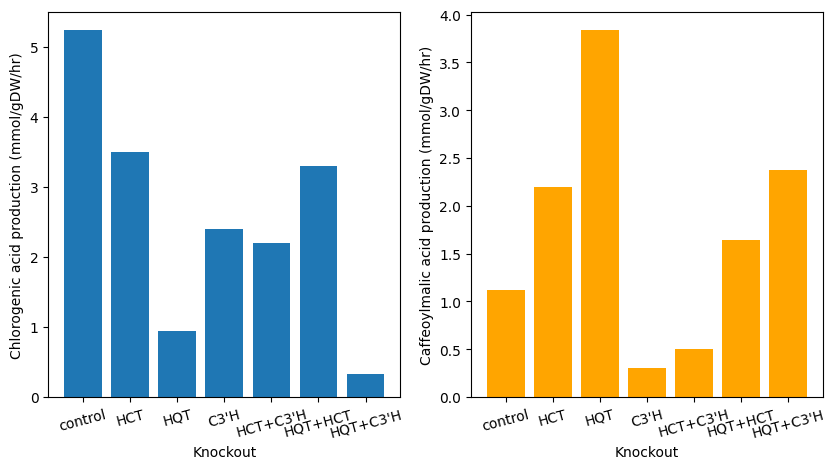

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(result_chlorogenic_acid.keys(), result_chlorogenic_acid.values())
plt.xlabel('Knockout')
plt.ylabel('Chlorogenic acid production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
plt.bar(result_caffeoylmalic_acid.keys(), result_caffeoylmalic_acid.values(), color='orange')
plt.xlabel('Knockout')
plt.ylabel('Caffeoylmalic acid production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)
plt.show()

#### 2.3 Analysis in Resveratol Model

In [21]:
# Resveratol
def Resveratol_model_copy(): # must be called every time
    model = FBA()

    met_1564 = model.model.metabolites.get_by_id('met_1564') # trans-resveratrol
    met_2484 = model.model.metabolites.get_by_id('met_2484') # (E)-4-coumaroyl-CoA
    met_0512 = model.model.metabolites.get_by_id('met_0512') # coenzymeA
    met_2307 = model.model.metabolites.get_by_id('met_2307') # malonyl-CoA
    met_0429 = model.model.metabolites.get_by_id('met_0429') # CO2
    met_2888 = model.model.metabolites.get_by_id('met_2888') # H2O
    met_0112 = model.model.metabolites.get_by_id("met_0112") # 3-deoxy-D-arabino-heptulosonate7-phosphate
    met_2544 = model.model.metabolites.get_by_id("met_2544") # phosphate
    met_2713 = model.model.metabolites.get_by_id("met_2713") # shikimate3-phosphate
    met_2386 = model.model.metabolites.get_by_id("met_2386") # NADPH
    met_2382 = model.model.metabolites.get_by_id("met_2382") # NADP+
    met_0367 = model.model.metabolites.get_by_id('met_0367') # ATP
    met_0304 = model.model.metabolites.get_by_id('met_0304') # ADP

    # ARO3
    ARO3 = cobra.Reaction('ARO3')
    ARO3.add_metabolites({met_0112:-1, met_2386:-1, met_0367:-1, met_2544:1, met_2888:1, met_2382:1, met_0304:1, met_2713:1})
    ARO3.bounds = (0,1000)

    # VvSTS
    R_VvSTS = cobra.Reaction('VvSTS')
    R_VvSTS.add_metabolites({met_2484: -1, met_2307: -3, met_1564: 1, met_0512: 4, met_0429: 4})
    R_VvSTS.bounds = (0, 1000)
    
    Resveratol_proc = cobra.Reaction('Resveratol_proc')
    Resveratol_proc.add_metabolites({met_1564:-1})
    Resveratol_proc.bounds = (0,1000)

    model.model.add_reactions([ARO3, R_VvSTS, Resveratol_proc])

    return model


# Resveratol_coef = 0.5804173
Resveratol_coef = 0.58041780
Resveratol_model_control = Resveratol_model_copy()

Resveratol_model_control.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (5.3, 5.4)

result_chlorogenic_acid2 = {}
result_Resveratol = {}
Resveratol_model_control.knock_out([])
result_chlorogenic_acid2['control'] = Print_res(Resveratol_model_control, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_control.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['control'] = Print_res(Resveratol_model_control, 'Resveratol_proc', 'met_0114', obj=Resveratol_coef * Resveratol_model_control.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145538232562977
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  5.3
balanced
1.8145538232562977
photosynthesis 0.88
CO2:  30.0 

reac_0090: 0.14652832167835142
reac_0430: 0.14652832167835142

Resveratol_proc:  1.8572849650349619


In [22]:
Resveratol_model_HCT = Resveratol_model_copy()
Resveratol_model_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.5, 5.4)
Resveratol_model_HCT.knock_out(['HCT'])
result_chlorogenic_acid2['HCT'] = Print_res(Resveratol_model_HCT, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_HCT.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['HCT'] = Print_res(Resveratol_model_HCT, 'Resveratol_proc','met_2831', obj=Resveratol_coef * Resveratol_model_HCT.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145534820806073
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  3.5
balanced
1.8145534820806073
photosynthesis 0.88
CO2:  30.0 

reac_0460: 1.761916379740505
reac_2659: 3.270953480538914
reac_2836: 0.0
reac_2489: 0.0
reac_2839: 0.0
reac_2834: 3.709437100798408
reac_2158: 0.0
reac_2833: 0.0004
reac_2838: 0.0
reac_2167: 1.1
reac_2837: 0.0
reac_0926: 0.0
reac_2840: 0.0
reac_1789: 0.0

Resveratol_proc:  1.8209534805389145


In [23]:
Resveratol_model_HQT = Resveratol_model_copy()
Resveratol_model_HQT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (0.95, 5.4)
Resveratol_model_HQT.model.reactions.get_by_id('DAHP_synthase').bounds = (6, 1000)
Resveratol_model_HQT.model.reactions.get_by_id('reac_0566').bounds = (0, 6)

Resveratol_model_HQT.knock_out(['HQT'])
result_chlorogenic_acid2['HQT'] = Print_res(Resveratol_model_HQT, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_HQT.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['HQT'] = Print_res(Resveratol_model_HQT, 'Resveratol_proc', 'met_0114',obj=Resveratol_coef * Resveratol_model_HQT.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145543664159254
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  0.95
balanced
1.8145543664159254
photosynthesis 0.88
CO2:  30.0 

reac_0090: 5.05
reac_0430: 5.05

Resveratol_proc:  2.9762493368700333


In [24]:
Resveratol_model_C3H = Resveratol_model_copy()
Resveratol_model_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (2.4, 5.4)
Resveratol_model_C3H.knock_out(['C3\'H'])
result_chlorogenic_acid2['C3\'H'] = Print_res(Resveratol_model_C3H, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_C3H.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['C3\'H'] = Print_res(Resveratol_model_C3H, 'Resveratol_proc', obj=Resveratol_coef * Resveratol_model_C3H.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.814553469257416
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  2.4
balanced
1.814553469257416
photosynthesis 0.88
CO2:  30.0 

Resveratol_proc:  1.9714036006546665


In [25]:
Resveratol_model_HCT_C3H = Resveratol_model_copy()
Resveratol_model_HCT_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (2.2, 5.4)
Resveratol_model_HCT_C3H.knock_out(['HCT', 'C3\'H'])
result_chlorogenic_acid2['HCT+C3\'H'] = Print_res(Resveratol_model_HCT_C3H, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_HCT_C3H.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['HCT+C3\'H'] = Print_res(Resveratol_model_HCT_C3H, 'Resveratol_proc', obj=Resveratol_coef * Resveratol_model_HCT_C3H.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145534820927225
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  2.2
balanced
1.8145534820927225
photosynthesis 0.88
CO2:  30.0 

Resveratol_proc:  2.012140633737188


In [26]:
Resveratol_model_HQT_HCT = Resveratol_model_copy()
Resveratol_model_HQT_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.3, 5.4)
Resveratol_model_HQT_HCT.knock_out(['HQT', 'HCT'])
result_chlorogenic_acid2['HQT+HCT'] = Print_res(Resveratol_model_HQT_HCT, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_HQT_HCT.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['HQT+HCT'] = Print_res(Resveratol_model_HQT_HCT, 'Resveratol_proc', obj=Resveratol_coef * Resveratol_model_HQT_HCT.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145534901807927
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  3.3
balanced
1.8145534901807927
photosynthesis 0.8
CO2:  30.0 

Resveratol_proc:  1.8575124668434988


In [27]:
Resveratol_model_HQT_C3H = Resveratol_model_copy()
Resveratol_model_HQT_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (0.35, 5.4)
Resveratol_model_HQT_C3H.knock_out(['HQT', 'C3\'H'])
result_chlorogenic_acid2['HQT+C3\'H'] = Print_res(Resveratol_model_HQT_C3H, 'chlorogenic_acid_proc', obj=Resveratol_coef * Resveratol_model_HQT_C3H.model.reactions.Resveratol_proc.flux_expression)
result_Resveratol['HQT+C3\'H'] = Print_res(Resveratol_model_HQT_C3H, 'Resveratol_proc', obj=Resveratol_coef * Resveratol_model_HQT_C3H.model.reactions.Resveratol_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145536434443845
photosynthesis 0.88
CO2:  30.0 

chlorogenic_acid_proc:  0.35
balanced
1.8145536434443845
photosynthesis 0.88
CO2:  30.0 

Resveratol_proc:  2.4265685730903463


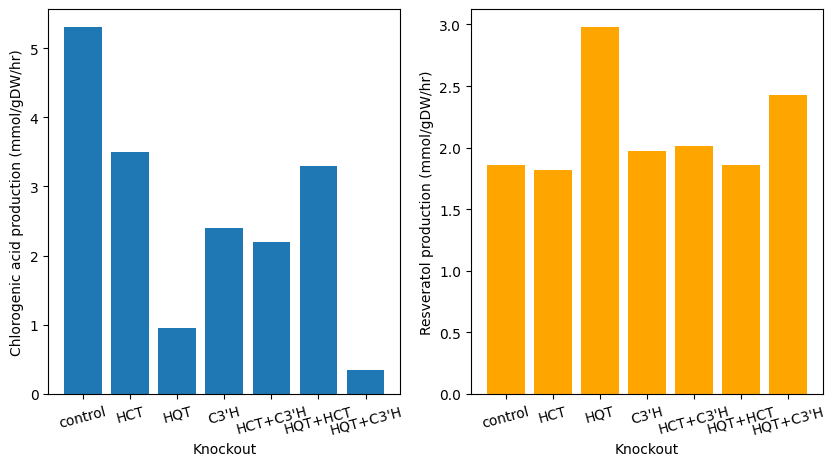

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(result_chlorogenic_acid2.keys(), result_chlorogenic_acid2.values())
plt.xlabel('Knockout')
plt.ylabel('Chlorogenic acid production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
plt.bar(result_Resveratol.keys(), result_Resveratol.values(), color='orange')
plt.xlabel('Knockout')
plt.ylabel('Resveratol production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)
plt.show()

#### 2.4 Analysis in Crocetin Model

In [29]:
# Crocin
def Crocetin_model_copy(): # must be called every time
    model = FBA()

    met_1580 = model.model.metabolites.get_by_id('met_1580') # Crocetin
    met_1716 = model.model.metabolites.get_by_id('met_1716')
    met_1714 = model.model.metabolites.get_by_id('met_1714')
    met_1707 = model.model.metabolites.get_by_id('met_1707') 
    met_2477 = model.model.metabolites.get_by_id('met_2477') # O2
    met_2591 = model.model.metabolites.get_by_id("met_2591") # H+
    met_2378 = model.model.metabolites.get_by_id("met_2378") # NADH
    met_2372 = model.model.metabolites.get_by_id("met_2372") # NAD+
    met_2888 = model.model.metabolites.get_by_id("met_2888") # H2O
    met_1120 = model.model.metabolites.get_by_id("met_1120") 
    Crocin = cobra.Metabolite('Crocin')
    Crocin_1 = cobra.Metabolite('Crocin_1')
    Crocin_2 = cobra.Metabolite('Crocin_2')
    Crocin_3 = cobra.Metabolite('Crocin_3')
    Crocin_4 = cobra.Metabolite('Crocin_4')
    Crocin_5 = cobra.Metabolite('Crocin_5')


    translycopene = cobra.Reaction('translycopene')
    translycopene.add_metabolites({met_1707:-1, met_2378:-2, met_2591:-2, met_2477:-4, met_1580:1, met_1120:2, met_2372:2, met_2888:2})
    translycopene.bounds = (0, 1000)

    transcarotene = cobra.Reaction('transcarotene')
    transcarotene.add_metabolites({met_1714:-1, met_2378:-2, met_2591:-2, met_2477:-4, met_1580:1, met_1120:2, met_2372:2, met_2888:2})
    transcarotene.bounds = (0, 1000)

    zeaxanthin = cobra.Reaction('zeaxanthin')
    zeaxanthin.add_metabolites({met_1716:-1, met_2477:-2, met_1580:1, met_1120:2})
    zeaxanthin.bounds = (0, 1000)

    Crocetin_proc = cobra.Reaction('Crocetin_proc')
    Crocetin_proc.add_metabolites({met_1580:-1, Crocin:1})
    Crocetin_proc.bounds = (-1000, 1000)

    R_9 = cobra.Reaction('R_9')
    R_9.add_metabolites({Crocin:-1, Crocin_4:1})
    R_9.bounds = (1, 1000)

    R_10 = cobra.Reaction('R_10')
    R_10.add_metabolites({Crocin:-1, Crocin_5:1})
    R_10.bounds = (0.2, 1)

    R_11 = cobra.Reaction('R_11')
    R_11.add_metabolites({Crocin_5:-1, Crocin_3:1})
    R_11.bounds = (0, 1000)

    R_12 = cobra.Reaction('R_12')
    R_12.add_metabolites({Crocin_3:-1, Crocin_1:1})
    R_12.bounds = (0, 1000)

    R_13 = cobra.Reaction('R_13')
    R_13.add_metabolites({Crocin_4:-1, Crocin_2:1})
    R_13.bounds = (0, 1000)

    R_14 = cobra.Reaction('R_14')
    R_14.add_metabolites({Crocin_4:-1, Crocin_1:1})
    R_14.bounds = (0, 0.4)

    R_15 = cobra.Reaction('R_15')
    R_15.add_metabolites({Crocin_2:-1, Crocin_1:1})
    #R_15.bounds = (0, 0.1)
    R_15.bounds = (0.01, 0.2)

    Crocetin_proc1 = cobra.Reaction('Crocetin_proc1')
    Crocetin_proc1.add_metabolites({Crocin_1:-1})
    Crocetin_proc1.bounds = (0, 1000)

    Crocetin_proc2 = cobra.Reaction('Crocetin_proc2')
    Crocetin_proc2.add_metabolites({Crocin_2:-1})
    Crocetin_proc2.bounds = (0, 1000)

    model.model.reactions.get_by_id('reac_2684').bounds = (0, 1000)
    model.model.reactions.get_by_id('reac_1949').bounds = (0, 1.2)
    model.model.reactions.get_by_id('reac_2362').bounds = (0, 0.6)


    model.model.add_reactions([R_9, R_10, R_11, R_12, R_13, R_14, R_15, translycopene, transcarotene, zeaxanthin, Crocetin_proc, Crocetin_proc1, Crocetin_proc2])


    return model


Crocetin_coef = 1.65835
# Crocetin_coef = 1.6584
Crocetin_model_control = Crocetin_model_copy()

Crocetin_model_control.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (5.3, 5.4)

result_Crocetin = {}
result_Crocin1 = {}
result_Crocin2 = {}
result_chlorogenic_acid3 = {}
Crocetin_model_control.knock_out([])
result_chlorogenic_acid3['control'] = Print_res(Crocetin_model_control, 'chlorogenic_acid_proc', obj=Crocetin_coef * Crocetin_model_control.model.reactions.Crocetin_proc.flux_expression)
result_Crocetin['control'] = Print_res(Crocetin_model_control, 'Crocetin_proc', 'met_1580', obj = Crocetin_coef *Crocetin_model_control.model.reactions.Crocetin_proc.flux_expression)
result_Crocin1['control'] = Print_res(Crocetin_model_control, 'Crocetin_proc1', obj = Crocetin_coef *Crocetin_model_control.model.reactions.Crocetin_proc.flux_expression)
result_Crocin2['control'] = Print_res(Crocetin_model_control, 'Crocetin_proc2', obj = Crocetin_coef *Crocetin_model_control.model.reactions.Crocetin_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145719057328877
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  5.3
balanced
1.8145719057328877
photosynthesis 0.8
CO2:  30.0 

translycopene: 0.011243973029045272
zeaxanthin: 1.2000000000000053
Crocetin_proc: 1.2112439730290505
reac_2478: 0.0
transcarotene: 0.0

Crocetin_proc:  1.2112439730290505
balanced
1.8145719057328877
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc1:  0.8
balanced
1.8145719057328877
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc2:  0.4112439730290452


In [30]:
Crocetin_model_HCT = Crocetin_model_copy()
# Crocetin_model_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (6.9, 7.2)
Crocetin_model_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.5, 6.9)
Crocetin_model_HCT.knock_out(['HCT'])
result_chlorogenic_acid3['HCT'] = Print_res(Crocetin_model_HCT, 'chlorogenic_acid_proc', obj=Crocetin_coef * Crocetin_model_HCT.model.reactions.Crocetin_proc.flux_expression)
result_Crocetin['HCT'] = Print_res(Crocetin_model_HCT, 'Crocetin_proc', obj=Crocetin_coef * Crocetin_model_HCT.model.reactions.Crocetin_proc.flux_expression)
result_Crocin1['HCT'] = Print_res(Crocetin_model_HCT, 'Crocetin_proc1', obj = Crocetin_coef*Crocetin_model_HCT.model.reactions.Crocetin_proc.flux_expression)
result_Crocin2['HCT'] = Print_res(Crocetin_model_HCT, 'Crocetin_proc2', obj = Crocetin_coef*Crocetin_model_HCT.model.reactions.Crocetin_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.814572557848317
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  3.5
balanced
1.814572557848317
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc:  1.2683708991228073
balanced
1.814572557848317
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc1:  0.8
balanced
1.814572557848317
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc2:  0.4683708991228073


In [31]:
Crocetin_model_HQT = Crocetin_model_copy()
Crocetin_model_HQT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (0.95, 5.4)
Crocetin_model_HQT.model.reactions.get_by_id('reac_1496').bounds = (1.7,1000)
Crocetin_model_HQT.model.reactions.get_by_id('reac_1950').bounds = (0,1.4)
Crocetin_model_HQT.model.reactions.get_by_id('reac_2370').bounds = (0,1.7)

Crocetin_model_HQT.knock_out(['HQT'])
result_chlorogenic_acid3['HQT'] = Print_res(Crocetin_model_HQT, 'chlorogenic_acid_proc', obj=Crocetin_coef * Crocetin_model_HQT.model.reactions.Crocetin_proc.flux_expression)
result_Crocetin['HQT'] = Print_res(Crocetin_model_HQT, 'Crocetin_proc','met_1580',obj=Crocetin_coef * Crocetin_model_HQT.model.reactions.Crocetin_proc.flux_expression)
result_Crocin1['HQT'] = Print_res(Crocetin_model_HQT, 'Crocetin_proc1', obj = Crocetin_coef *Crocetin_model_HQT.model.reactions.Crocetin_proc.flux_expression)
result_Crocin2['HQT'] = Print_res(Crocetin_model_HQT, 'Crocetin_proc2', obj = Crocetin_coef *Crocetin_model_HQT.model.reactions.Crocetin_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.814579326666665
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  0.95
balanced
1.814579326666665
photosynthesis 0.8
CO2:  30.0 

transcarotene: 0.0
reac_2478: 0.0
translycopene: 0.5
zeaxanthin: 1.2
Crocetin_proc: 1.7

Crocetin_proc:  1.7
balanced
1.814579326666665
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc1:  0.8
balanced
1.814579326666665
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc2:  0.9000000000000001


In [32]:
Crocetin_model_C3H = Crocetin_model_copy()
Crocetin_model_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (2.4, 5.4)
Crocetin_model_C3H.knock_out(['C3\'H'])
result_chlorogenic_acid3['C3\'H'] = Print_res(Crocetin_model_C3H, 'chlorogenic_acid_proc', obj=Crocetin_coef*Crocetin_model_C3H.model.reactions.Crocetin_proc.flux_expression)
result_Crocetin['C3\'H'] = Print_res(Crocetin_model_C3H, 'Crocetin_proc', obj = Crocetin_coef*Crocetin_model_C3H.model.reactions.Crocetin_proc.flux_expression)
result_Crocin1['C3\'H'] = Print_res(Crocetin_model_C3H, 'Crocetin_proc1', obj = Crocetin_coef*Crocetin_model_C3H.model.reactions.Crocetin_proc.flux_expression)
result_Crocin2['C3\'H'] = Print_res(Crocetin_model_C3H, 'Crocetin_proc2', obj = Crocetin_coef*Crocetin_model_C3H.model.reactions.Crocetin_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145736599421325
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  2.4
balanced
1.8145736599421325
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc:  1.345496527777777
balanced
1.8145736599421325
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc1:  0.8
balanced
1.8145736599421325
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc2:  0.545496527777777


In [33]:
Crocetin_model_HCT_C3H = Crocetin_model_copy()
Crocetin_model_HCT_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (2.2, 5.4)
Crocetin_model_HCT_C3H.knock_out(['HCT', 'C3\'H'])
result_chlorogenic_acid3['HCT+C3\'H'] = Print_res(Crocetin_model_HCT_C3H, 'chlorogenic_acid_proc', obj=Crocetin_coef * Crocetin_model_HCT_C3H.model.reactions.Crocetin_proc.flux_expression)
result_Crocetin['HCT+C3\'H'] = Print_res(Crocetin_model_HCT_C3H, 'Crocetin_proc', obj=Crocetin_coef * Crocetin_model_HCT_C3H.model.reactions.Crocetin_proc.flux_expression)
result_Crocin1['HCT+C3\'H'] = Print_res(Crocetin_model_HCT_C3H, 'Crocetin_proc1', obj = Crocetin_coef *Crocetin_model_HCT_C3H.model.reactions.Crocetin_proc.flux_expression)
result_Crocin2['HCT+C3\'H'] = Print_res(Crocetin_model_HCT_C3H, 'Crocetin_proc2', obj = Crocetin_coef *Crocetin_model_HCT_C3H.model.reactions.Crocetin_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.814574280997635
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  2.2
balanced
1.814574280997635
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc:  1.3847598582848812
balanced
1.814574280997635
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc1:  0.8
balanced
1.814574280997635
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc2:  0.5847598582848827


In [34]:
Crocetin_model_HQT_HCT = Crocetin_model_copy()
Crocetin_model_HQT_HCT.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (3.3, 5.4)
Crocetin_model_HQT_HCT.knock_out(['HQT+HCT'])
result_chlorogenic_acid3['HQT+HCT'] = Print_res(Crocetin_model_HQT_HCT, 'chlorogenic_acid_proc', obj=Crocetin_coef * Crocetin_model_HQT_HCT.model.reactions.Crocetin_proc.flux_expression)
result_Crocetin['HQT+HCT'] = Print_res(Crocetin_model_HQT_HCT, 'Crocetin_proc','met_1580', obj=Crocetin_coef * Crocetin_model_HQT_HCT.model.reactions.Crocetin_proc.flux_expression)
result_Crocin1['HQT+HCT'] = Print_res(Crocetin_model_HQT_HCT, 'Crocetin_proc1', obj = Crocetin_coef *Crocetin_model_HQT_HCT.model.reactions.Crocetin_proc.flux_expression)
result_Crocin2['HQT+HCT'] = Print_res(Crocetin_model_HQT_HCT, 'Crocetin_proc2', obj = Crocetin_coef *Crocetin_model_HQT_HCT.model.reactions.Crocetin_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145732138772468
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  3.3
balanced
1.8145732138772468
photosynthesis 0.8
CO2:  30.0 

translycopene: 0.10973263477213803
Crocetin_proc: 1.309732634772138
transcarotene: 0.0
reac_2478: 0.0
zeaxanthin: 1.2

Crocetin_proc:  1.309732634772138
balanced
1.8145732138772468
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc1:  0.8
balanced
1.8145732138772468
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc2:  0.509732634772138


In [35]:
Crocetin_model_HQT_C3H = Crocetin_model_copy()
Crocetin_model_HQT_C3H.model.reactions.get_by_id('chlorogenic_acid_proc').bounds = (0.35, 5.4)
Crocetin_model_HQT_C3H.knock_out(['HQT', 'C3\'H'])
result_chlorogenic_acid3['HQT+C3\'H'] = Print_res(Crocetin_model_HQT_C3H, 'chlorogenic_acid_proc', obj=Crocetin_coef * Crocetin_model_HQT_C3H.model.reactions.Crocetin_proc.flux_expression)
result_Crocetin['HQT+C3\'H'] = Print_res(Crocetin_model_HQT_C3H, 'Crocetin_proc', 'met_1580', obj=Crocetin_coef * Crocetin_model_HQT_C3H.model.reactions.Crocetin_proc.flux_expression)
result_Crocin1['HQT+C3\'H'] = Print_res(Crocetin_model_HQT_C3H, 'Crocetin_proc1', obj = Crocetin_coef *Crocetin_model_HQT_C3H.model.reactions.Crocetin_proc.flux_expression)
result_Crocin2['HQT+C3\'H'] = Print_res(Crocetin_model_HQT_C3H, 'Crocetin_proc2', obj = Crocetin_coef *Crocetin_model_HQT_C3H.model.reactions.Crocetin_proc.flux_expression)

'' is not a valid SBML 'SId'.


balanced
1.8145757397278666
photosynthesis 0.8
CO2:  30.0 

chlorogenic_acid_proc:  0.35
balanced
1.8145757397278666
photosynthesis 0.8
CO2:  30.0 

transcarotene: 0.0
zeaxanthin: 1.2
Crocetin_proc: 1.4907836720633822
translycopene: 0.2907836720633823
reac_2478: 0.0

Crocetin_proc:  1.4907836720633822
balanced
1.8145757397278666
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc1:  0.8
balanced
1.8145757397278666
photosynthesis 0.8
CO2:  30.0 

Crocetin_proc2:  0.6907836720633822


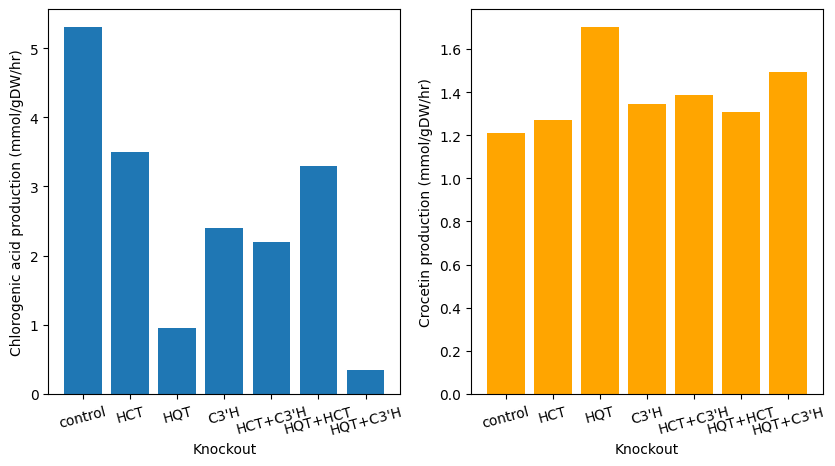

In [36]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(result_chlorogenic_acid3.keys(), result_chlorogenic_acid3.values())
plt.xlabel('Knockout')
plt.ylabel('Chlorogenic acid production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
plt.bar(result_Crocetin.keys(), result_Crocetin.values(), color='orange')
plt.xlabel('Knockout')
plt.ylabel('Crocetin production (mmol/gDW/hr)', fontsize=10)
plt.xticks(rotation=15)
plt.show()

#### 3. dFBA

In [37]:
end_t = 168

#### 3.1 Caffeoylmalic Acid

In [38]:
r = 0.062  # Rate to reach the balance flux
t_0 = 50  # Midpoint of the 'S'-curve
threshold = 62
decay = 0.001

def add_dynamic_bounds_caffeoylmalic_acid(model, t, y, balanced_flux):
    """
    Use external concentrations to bound the uptake flux of Caffeoylmalic Acid.
    """

    # Adjust the bounds for Caffeoylmalic_acid_proc
    Caffeoylmalic_acid_proc = model.model.reactions.get_by_id('Caffeoylmalic_acid_proc')
    if t <= threshold:
        Caffeoylmalic_acid_proc.upper_bound = balanced_flux / (1 + exp(-r * (t - t_0)))
    if t > threshold:
        Caffeoylmalic_acid_proc.upper_bound = max(Caffeoylmalic_acid_proc.upper_bound - decay * (t - threshold), 0)
    # flux: mmol/gDW/h

def dynamic_system_caffeoylmalic_acid(t, y, k, model, balanced_flux):
    """
    Calculate the time derivative of Caffeoylmalic Acid.
    """
    Caffeoylmalic_Acid = y[0]

    add_dynamic_bounds_caffeoylmalic_acid(model, t, y, balanced_flux)
    solution = model.model.optimize()
    HCT_M1 = solution.fluxes.get('HCT_M1')
    proc_flux = solution.fluxes.get('Caffeoylmalic_acid_proc')
    print(HCT_M1, proc_flux, Caffeoylmalic_Acid)

    # with open('csv/caff.csv', mode='a', newline='') as file:
        # writer = csv.writer(file)
        # writer.writerow([t, HCT_M1, proc_flux, Caffeoylmalic_Acid])

    inhibit = min(Caffeoylmalic_Acid / (k * balanced_flux), 0.98)
    d_caffeoylmalic_acid_dt = Dry2Wet * proc_flux * (1 - inhibit)
    # proc_flux: mmol/gDW/h (Assume that 1gDW = 10gFW)
    # Caffeoylmalic_Acid: mmol/gFW
    # k: rate of counter-reaction

    return [d_caffeoylmalic_acid_dt]

def sens_analysis(dynamic_system, k, model, flux, y0):
    """
    Perform sensitivity analysis by varying k_reaction, with dynamic initial condition y0.
    """
    t_span = (0, end_t)

    # Generate a dense set of time points
    t_eval = np.linspace(t_span[0], t_span[1], 100)

    results = {}
    for k_reaction in k:
        solution = solve_ivp(dynamic_system, t_span, y0, args=(k_reaction, model, flux), method='RK45', t_eval=t_eval)
        results[k_reaction] = solution.y[0]  # Store Phaselic Acid concentration

    return results


In [39]:
k_fixed = 1.4

# 定义不同的初始条件
init_caffeoylmalic_acid_control = 0.18
init_caffeoylmalic_acid_HQT = 0.48

# Sensitivity analysis for Control group
sens_results_control = sens_analysis(dynamic_system_caffeoylmalic_acid, [k_fixed], Caff_model_control, result_caffeoylmalic_acid['control'], [init_caffeoylmalic_acid_control])

# Sensitivity analysis for HQT group
sens_results_HQT = sens_analysis(dynamic_system_caffeoylmalic_acid, [k_fixed], Caff_model_HQT, result_caffeoylmalic_acid['HQT'], [init_caffeoylmalic_acid_HQT])

time_points = np.linspace(0, end_t, 100)

# 提取结果
caff_control = sens_results_control[k_fixed]
caff_HQT = sens_results_HQT[k_fixed]

C:\Users\yzy\PycharmProjects\Quantitative modeling\venv\lib\site-packages\cobra\core\reaction.py:327: ComplexWarning: Casting complex values to real discards the imaginary part
  lb=0, ub=None if isinf(self._upper_bound) else self._upper_bound
C:\Users\yzy\PycharmProjects\Quantitative modeling\venv\lib\site-packages\optlang\glpk_interface.py:799: ComplexWarning: Casting complex values to real discards the imaginary part
  GLP_DB, float(variable.lb), float(variable.ub))


0.048142650930588005 0.04814265093058974 0.18
0.0493640266859563 0.04936402668594948 0.1818
0.04826370768281363 0.04826370768281833 0.1801803415307474
0.048324345002278335 0.04832434500227804 0.18027099594504206
0.04862862417521985 0.04862862417521799 0.18072481074477204
0.048682909362077975 0.04868290936208014 0.18080577087929353
0.048750847182324364 0.048750847182321894 0.18090709298498098
0.048750847182324364 0.048750847182321894 0.18090709451648662
0.0499893045970925 0.04998930459709042 0.1827320954294669
0.0506197249785294 0.050619724978525224 0.18369397424597317
0.05388698444614226 0.05388698444614655 0.18856364760050767
0.054488419185378056 0.05448841918537354 0.1894586211655527
0.055249169925311925 0.055249169925307574 0.19059230852819622
0.055249169925311925 0.055249169925307574 0.19059410945674993
0.07078037811317106 0.07078037811316787 0.21113187533372402
0.07999522847727825 0.07999522847727476 0.22745306248998062
0.1445781954136902 0.14457819541368339 0.3216643048874256
0.1

C:\Users\yzy\PycharmProjects\Quantitative modeling\venv\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


0.25969999999999915 0.25969999999999915 0.48129580203687417
0.25969999999999915 0.25969999999999915 0.4834547093980244
0.25969999999999915 0.25969999999999915 0.4838384158116761
0.25969999999999915 0.25969999999999915 0.48431800574078016
0.25969999999999915 0.25969999999999915 0.4843180050151816
0.25969999999999915 0.25969999999999915 0.49295020109377086
0.25969999999999915 0.25969999999999915 0.49724914140356213
0.25969999999999915 0.25969999999999915 0.5187253177273682
0.25969999999999915 0.25969999999999915 0.5225338674512531
0.25969999999999915 0.25969999999999915 0.5272896315434344
0.25969999999999915 0.25969999999999915 0.5272889041052883
0.25969999999999915 0.25969999999999915 0.6128516574811628
0.25969999999999915 0.25969999999999915 0.6539323515564476
0.43002804635120395 0.4300280463512035 0.8579803535014768
0.4699931157840763 0.46999311578407515 0.8177903578981467
0.5244027312242968 0.5244027312242968 0.9193695182529056
0.5244027312242968 0.5244027312242968 1.0524953827128427

#### 3.2 Resveratrol

In [40]:
r = 0.066  # Rate to reach the balance flux
t_0 = 42  # Midpoint of the 'S'-curve
threshold = 55
decay = 0.001

def add_dynamic_bounds_resveratol(model, t, y, balanced_flux):
    """
    Use external concentrations to bound the uptake flux of Resveratol.
    """

    # Adjust the bounds for Caffeoylmalic_acid_proc
    Resveratol_proc = model.model.reactions.get_by_id('Resveratol_proc')
    if t <= threshold:
        Resveratol_proc.upper_bound = balanced_flux / (1 + exp(-r * (t - t_0)))
    if t > threshold:
        Resveratol_proc.upper_bound = max(Resveratol_proc.upper_bound - decay * (t - threshold), 0)

    # flux: mmol/gDW/h

def dynamic_system_resveratol(t, y, k, model, balanced_flux):
    """
    Calculate the time derivative of Resveratol.
    """
    Resveratol = y[0]

    add_dynamic_bounds_resveratol(model, t, y, balanced_flux)
    solution = model.model.optimize()
    R_VvSTS = solution.fluxes.get('VvSTS')
    proc_flux = solution.fluxes.get('Resveratol_proc')
    print(R_VvSTS, proc_flux, Resveratol)


    inhibit = min(Resveratol / (k * balanced_flux), 0.982)
    d_resveratol_dt = Dry2Wet * R_VvSTS * (1 - inhibit)
    # proc_flux: mmol/gDW/h (Assume that 1gDW = 10gFW)
    # Resveratol: mmol/gFW
    # k: rate of counter-reaction

    return [d_resveratol_dt]

def sens_analysis(dynamic_system, k, model, flux, y0):
    """
    Perform sensitivity analysis by varying k_reaction, with dynamic initial condition y0.
    """
    t_span = (0, end_t)

    # Generate a dense set of time points
    t_eval = np.linspace(t_span[0], t_span[1], 100)  # Increased number of time points

    results = {}
    for k_reaction in k:
        solution = solve_ivp(dynamic_system, t_span, y0, args=(k_reaction, model, flux), method='RK45', t_eval=t_eval)
        results[k_reaction] = solution.y[0]  # Store Resveratol concentration

    return results

In [41]:
k_fixed = 1.5

init_resveratol_control = 0.13
init_resveratol_HQT = 0.22

sens_results_control = sens_analysis(dynamic_system_resveratol, [k_fixed], Resveratol_model_control, result_Resveratol['control'], [init_resveratol_control])
sens_results_HQT = sens_analysis(dynamic_system_resveratol, [k_fixed], Resveratol_model_HQT, result_Resveratol['HQT'], [init_resveratol_HQT])

time_points = np.linspace(0, end_t, 100)

res_control = sens_results_control[k_fixed]
res_HQT = sens_results_HQT[k_fixed]

0.10931260813021693 0.10931260813021793 0.13
0.11016271726944016 0.1101627172694414 0.1313
0.10953813107593424 0.10953813107593353 0.130345794103949
0.10965105602596914 0.10965105602596949 0.130519442986521
0.1102173191608733 0.11021731916087289 0.13138852897440242
0.11031827458060306 0.11031827458060099 0.13154347086837095
0.11044459068243961 0.11044459068244285 0.13173733742186539
0.11044459068243961 0.11044459068244285 0.13173733978253557
0.11274156824978254 0.11274156824978336 0.13522880400876083
0.11390674535623546 0.11390674535623403 0.13705095235795603
0.11990319375105374 0.1199031937510593 0.14625284477570571
0.12099954811614966 0.12099954811615318 0.14793350837188282
0.12238310529500973 0.12238310529501133 0.15005698968381076
0.12238310529500973 0.12238310529501133 0.1500595930110732
0.14992761702985913 0.14992761702986282 0.18848126169625878
0.1657291385325368 0.16572913853253526 0.21664865172479242
0.26903459984839495 0.2690345998483932 0.3736918573452541
0.2922103659235771 

##### merge two pictures

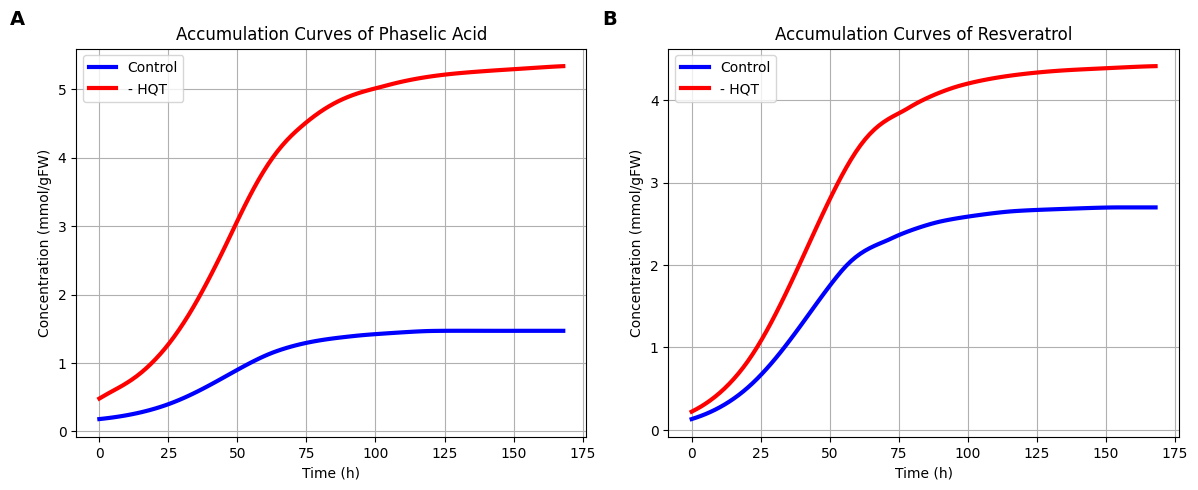

In [58]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

caff_ratio = caff_HQT / caff_control
res_ratio = res_HQT / res_control

# Plot Phaselic Acid on the left
axes[0].plot(time_points, caff_control, label='Control', linestyle='-', color='b', linewidth=3)
axes[0].plot(time_points, caff_HQT, label='- HQT', linestyle='-', color='r', linewidth=3)
# axes[0].plot(time_points, caff_ratio, label='HQT / Control', linestyle='-', color='g', linewidth=3)
axes[0].set_xlabel('Time (h)')
axes[0].set_ylabel('Concentration (mmol/gFW)')
axes[0].set_title('Accumulation Curves of Phaselic Acid')
axes[0].legend()
axes[0].grid(True)
axes[0].text(-0.1, 1.1, 'A', transform=axes[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# Plot Resveratrol on the right
axes[1].plot(time_points, res_control, label='Control', linestyle='-', color='b', linewidth=3)
axes[1].plot(time_points, res_HQT, label='- HQT', linestyle='-', color='r', linewidth=3)
# axes[1].plot(time_points, res_ratio, label='HQT / Control', linestyle='-', color='g', linewidth=3)
axes[1].set_xlabel('Time (h)')
axes[1].set_ylabel('Concentration (mmol/gFW)')
axes[1].set_title('Accumulation Curves of Resveratrol')
axes[1].legend()
axes[1].grid(True)
axes[1].text(-0.1, 1.1, 'B', transform=axes[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("pic/crocin_dfba_separate_with_labels", bbox_inches='tight', dpi=300)
plt.show()

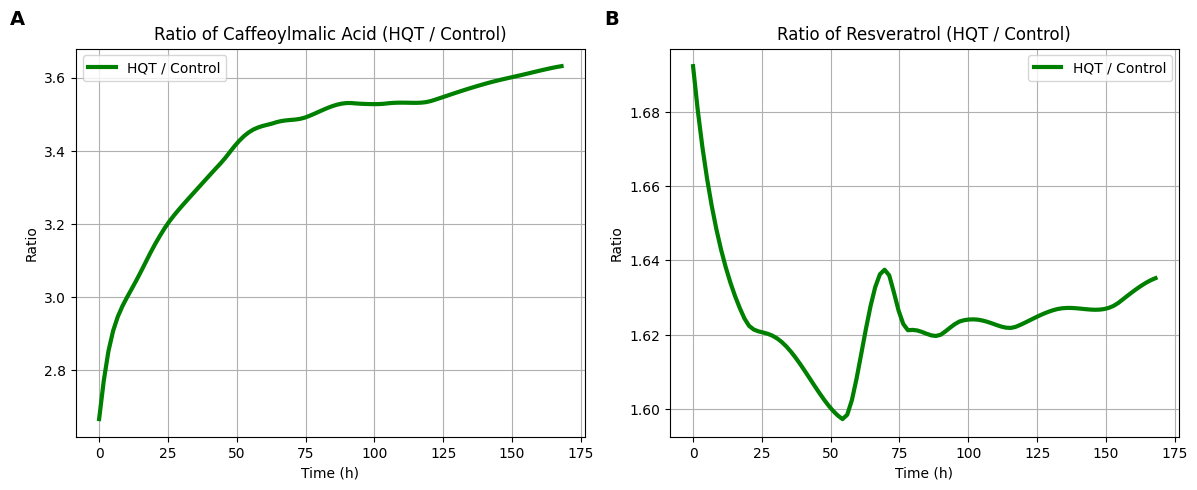

In [43]:
# Create a new figure for the ratio plots
fig_ratio, axes_ratio = plt.subplots(1, 2, figsize=(12, 5))

# Plot Caffeoylmalic Acid ratio on the left
axes_ratio[0].plot(time_points, caff_ratio, label='HQT / Control', linestyle='-', color='g', linewidth=3)
axes_ratio[0].set_xlabel('Time (h)')
axes_ratio[0].set_ylabel('Ratio')
axes_ratio[0].set_title('Ratio of Caffeoylmalic Acid (HQT / Control)')
axes_ratio[0].legend()
axes_ratio[0].grid(True)
axes_ratio[0].text(-0.1, 1.1, 'A', transform=axes_ratio[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# Plot Resveratrol ratio on the right
axes_ratio[1].plot(time_points, res_ratio, label='HQT / Control', linestyle='-', color='g', linewidth=3)
axes_ratio[1].set_xlabel('Time (h)')
axes_ratio[1].set_ylabel('Ratio')
axes_ratio[1].set_title('Ratio of Resveratrol (HQT / Control)')
axes_ratio[1].legend()
axes_ratio[1].grid(True)
axes_ratio[1].text(-0.1, 1.1, 'B', transform=axes_ratio[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("pic/crocin_ratio_hqt_control", bbox_inches='tight', dpi=300)
plt.show()

#### 3.3 Crocin

In [44]:
end_t=168

r1 = 0.052  # Rate to reach the balance flux
t1_0 = 40  # Midpoint of the 'S'-curve
threshold1 = 55
decay1 = 0.0005

r2 = 0.076  # Rate to reach the balance flux
t2_0 = 30  # Midpoint of the 'S'-curve
threshold2 = 50
decay2 = 0.001

k1 = 2.6
k2 = 1.1
result_Crocin1['HQT']=result_Crocin1['HQT']+0.25
result_Crocin2['HQT']=result_Crocin2['HQT']-0.2

def add_dynamic_bounds_crocin(model, t, y, knockout):
    """
    Use external concentrations to bound the uptake flux of Crocin 1&2.
    """
    crocin_1, crocin_2 = y

    flux1 = result_Crocin1[knockout]
    flux2 = result_Crocin2[knockout]

    # Adjust the bounds for reaction Crocetin_proc1
    Crocetin_proc1 = model.model.reactions.get_by_id('Crocetin_proc1')
    if t <= threshold1:
        Crocetin_proc1.upper_bound = flux1 / (1 + exp(-r1 * (t - t1_0)))
    elif t > threshold1:
        Crocetin_proc1.upper_bound = max(Crocetin_proc1.upper_bound - decay1 * (t - threshold1), 0)

    # Adjust the bounds for reaction Crocetin_proc2
    Crocetin_proc2 = model.model.reactions.get_by_id('Crocetin_proc2')
    if t <= threshold2:
        Crocetin_proc2.upper_bound = flux2 / (1 + exp(-r2 * (t - t2_0)))
    elif t > threshold2:
        Crocetin_proc2.upper_bound = max(Crocetin_proc2.upper_bound - decay2 * (t - threshold2), 0)

    # Adjust the bounds for reaction R_15
    R_15 = model.model.reactions.get_by_id('R_15')
    R_15.upper_bound = max(1.2 * crocin_2 / (0.4 + crocin_2), 0.3)

    print(Crocetin_proc2.bounds, R_15.bounds)

def dynamic_system_crocin(t, y, model, knockout):
    """
    Calculate the time derivative of Crocin 1&2.
    """
    crocin_1, crocin_2 = y

    add_dynamic_bounds_crocin(model, t, [crocin_1, crocin_2], knockout)
    solution = model.model.optimize()
    crocin1_proc_flux = solution.fluxes.get('Crocetin_proc1')
    crocin2_proc_flux = solution.fluxes.get('Crocetin_proc2')
    R_15 = solution.fluxes.get('R_15')

    Crocetin_proc1 = model.model.reactions.get_by_id('Crocetin_proc1')
    crocin1_proc_flux = Crocetin_proc1.upper_bound
    Crocetin_proc2 = model.model.reactions.get_by_id('Crocetin_proc2')
    crocin2_proc_flux = Crocetin_proc2.upper_bound
    print(crocin1_proc_flux, crocin2_proc_flux, R_15)

    inhibit1 = min(crocin_1 / (k1 * result_Crocin1[knockout]), 0.98)
    inhibit2 = min(crocin_2 / (k2 * result_Crocin2[knockout]), 0.95)

    d_crocin1_dt = Dry2Wet * crocin1_proc_flux * (1 - inhibit1)
    d_crocin2_dt = Dry2Wet * crocin2_proc_flux * (1 - inhibit2)

    # proc_flux: mmol/gDW/h (Assume that 1gDW = 10gFW)
    # Resveratol: mmol/gFW
    # k: rate of counter-reaction

    return [d_crocin1_dt, d_crocin2_dt]

In [45]:
# Define initial concentrations for Control group
init_crocin1_control = 0.12
init_crocin2_control = 0.02
y0_control = [init_crocin1_control, init_crocin2_control]

# Define initial concentrations for HQT group
init_crocin1_HQT = 0.16  # Set a different value for HQT
init_crocin2_HQT = 0.03   # Set a different value for HQT
y0_HQT = [init_crocin1_HQT, init_crocin2_HQT]

# Time span and evaluation points
t_span = (0, end_t)
t_eval = np.linspace(t_span[0], t_span[1], 100)  # Increased number of time points

# Solve for Control group
solution_control = solve_ivp(dynamic_system_crocin, t_span, y0_control,
                              args=(Crocetin_model_control, 'control'), method='RK45',
                              t_eval=t_eval)

# Solve for HQT group
solution_HQT = solve_ivp(dynamic_system_crocin, t_span, y0_HQT,
                          args=(Crocetin_model_HQT, 'HQT'), method='RK45',
                          t_eval=t_eval)

(0, (0.038160542708997575+0j)) (0.01, 0.3)
(0.08884477336912605+0j) (0.038160542708997575+0j) 0.3
(0, (0.03835448730295591+0j)) (0.01, 0.3)
(0.08914726283037189+0j) (0.03835448730295591+0j) 0.3
(0, (0.03823948725395271+0j)) (0.01, 0.3)


C:\Users\yzy\PycharmProjects\Quantitative modeling\venv\lib\site-packages\scipy\integrate\_ivp\base.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


(0.08896795831023936+0j) (0.03823948725395271+0j) 0.3
(0, (0.038279014467206586+0j)) (0.01, 0.3)
(0.08902960679861449+0j) (0.038279014467206586+0j) 0.3
(0, (0.03847720095416187+0j)) (0.01, 0.3)
(0.08933841002786419+0j) (0.03847720095416187+0j) 0.3
(0, (0.038512530300064254+0j)) (0.01, 0.3)
(0.08939340632052506+0j) (0.038512530300064254+0j) 0.3
(0, (0.03855673288459578+0j)) (0.01, 0.3)
(0.08946219330442795+0j) (0.03855673288459578+0j) 0.3
(0, (0.03855673288459578+0j)) (0.01, 0.3)
(0.08946219330442795+0j) (0.03855673288459578+0j) 0.3
(0, (0.039360190003731144+0j)) (0.01, 0.3)
(0.09070828995314516+0j) (0.039360190003731144+0j) 0.3
(0, (0.03976750755724382+0j)) (0.01, 0.3)
(0.09133699697785153+0j) (0.03976750755724382+0j) 0.3
(0, (0.04186099560145365+0j)) (0.01, 0.3)
(0.09453772100067906+0j) (0.04186099560145365+0j) 0.3
(0, (0.04224325093128558+0j)) (0.01, 0.3)
(0.09511680698731231+0j) (0.04224325093128558+0j) 0.3
(0, (0.042725414301477666+0j)) (0.01, 0.3)
(0.09584497720830941+0j) (0.04272

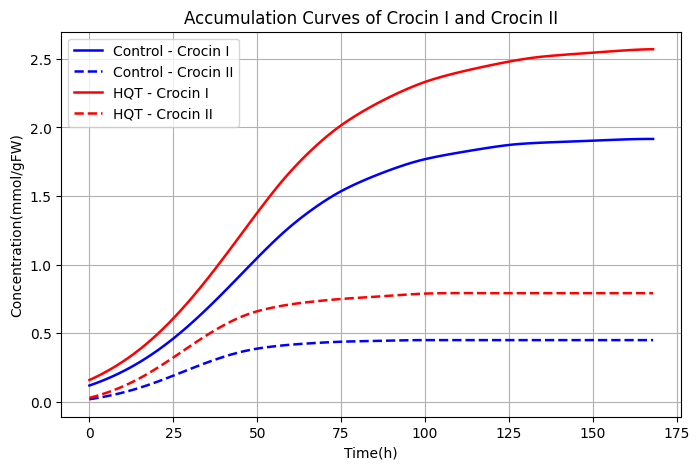

In [46]:
plt.figure(figsize=(8, 5))

plt.plot(t_eval, solution_control.y[0], label='Control - Crocin I', color='blue', linestyle='-', linewidth=1.8)
plt.plot(t_eval, solution_control.y[1], label='Control - Crocin II', color='blue', linestyle='--', linewidth=1.8)
plt.plot(t_eval, solution_HQT.y[0], label='HQT - Crocin I', color='red', linestyle='-', linewidth=1.8)
plt.plot(t_eval, solution_HQT.y[1], label='HQT - Crocin II', color='red', linestyle='--', linewidth=1.8)

plt.xlabel('Time(h)')
plt.ylabel('Concentration(mmol/gFW)')
plt.title('Accumulation Curves of Crocin I and Crocin II')
plt.legend()
plt.grid(True)
plt.savefig("pic/crocin_dfba", bbox_inches='tight', dpi=300)
plt.show()

#### 3.4 Result Visualization (Control and -HQT)

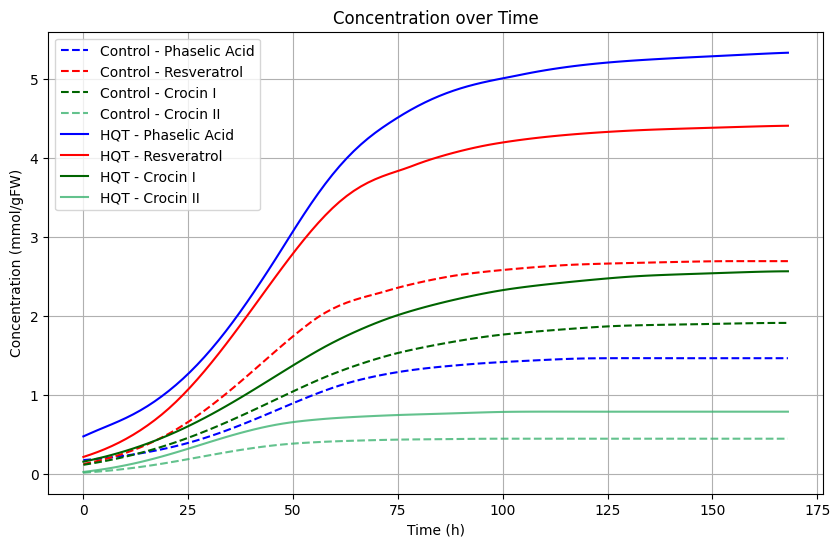

In [47]:
plt.figure(figsize=(10, 6))

plt.plot(time_points, caff_control, label='Control - Phaselic Acid', linestyle='--', color='b')
plt.plot(time_points, res_control, label='Control - Resveratrol', linestyle='--', color='r')
plt.plot(t_eval, solution_control.y[0], label='Control - Crocin I', linestyle='--', color='darkgreen', alpha=1)
plt.plot(t_eval, solution_control.y[1], label='Control - Crocin II', linestyle='--', color='mediumseagreen', alpha=0.8)

plt.plot(time_points, caff_HQT, label='HQT - Phaselic Acid', linestyle='-', color='b')
plt.plot(time_points, res_HQT, label='HQT - Resveratrol', linestyle='-', color='r')
plt.plot(t_eval, solution_HQT.y[0], label='HQT - Crocin I', linestyle='-', color='darkgreen', alpha=1)
plt.plot(t_eval, solution_HQT.y[1], label='HQT - Crocin II', linestyle='-', color='mediumseagreen', alpha=0.8)

plt.xlabel('Time (h)')
plt.ylabel('Concentration (mmol/gFW)')
plt.title('Concentration over Time')
plt.legend()
plt.grid(True)
plt.savefig("pic/all_dfba", bbox_inches='tight', dpi=300)
plt.show()

### 4. ROI

In [48]:
end_t = 1440

#### 4.2 Resveratrol

In [49]:
end_t = 1176
r = 0.022  # Rate to reach the balance flux
t_0 = 400  # Midpoint of the 'S'-curve
threshold = 560
decay = 0.0001

def resveratol_time_func(model, flux):
    """
    Returns a dictionary of functions that represent the concentration of Resveratol over time.
    """
    init_resveratol = 0.0
    y0 = [init_resveratol]
    t_span = (0, end_t)

    # Generate a dense set of time points
    t_eval = np.linspace(t_span[0], t_span[1], 100)  # Increased number of time points

    # Solve the differential equation
    solution = solve_ivp(dynamic_system_resveratol, t_span, y0, args=(2.8, model, flux), method='RK45', t_eval=t_eval)

    # Create a lambda function to interpolate concentrations over time
    concentration_t_func = lambda t_val: np.interp(t_val, solution.t, solution.y[0])

    return concentration_t_func

In [50]:
q = resveratol_time_func(model=Resveratol_model_HQT, flux=result_Resveratol['HQT'])

'''Value of resveratrol'''
p = 581.4 # RMB/(mmol/gFW)
# Leaf: 1700gFW  Dry2Wet: 0.1
# For 98% resveratol:
# 1500 yuan/kg = 1.5 yuan/g
# C14_H12_O3 228g/mol
# 1.5 yuan/g * 228 g/mol * 1e-3 = 0.342 yuan/mmol
# 0.342 yuan/mmol * 1700gFW = 581.4 yuan/(mmol/gFW)

'''market demand quantity'''
Qd = 1

'''Cost'''
# Ignore initial investment for a factory or laboratory
material_cost = 100
transfection_cost = 50
product_puri_cost = 600
FC = material_cost + transfection_cost + product_puri_cost # Fixed Cost
hour_cost = 5.4
def c(t): # Changeable Cost
    """Cost of plant growth."""
    return hour_cost * t

"""Income"""
def profit_over_time(t, q, p, c, FC):
    """Calculate income over time based on q(t)."""
    return Qd * p * q(t) - c(t) - FC

"""ROI"""
def ROI(t, q, p, c, FC):
    """Calculate ROI over time."""
    return ((Qd * p * q(t) - c(t) - FC) / (c(t) + FC)) * 100

0.0004485516032347991 0.0004485516032347991 0.0
0.00044855161310144726 0.00044855161310144726 4.485516032347991e-11
0.0004485518005678029 0.0004485518005678029 8.971032064695981e-10
0.00044855189923433776 0.00044855189923433776 1.3456552535950107e-09
0.0004485523925673367 0.0004485523925673367 3.5884159824350363e-09
0.00044855248027103785 0.00044855248027103785 3.987129259070894e-09
0.00044855258990068777 0.00044855258990068777 4.485520964468488e-09
0.00044855258990068777 0.00044855258990068777 4.485520964468456e-09
0.0004485545632389759 0.0004485545632389759 1.3456572757653528e-08
0.0004485555499113755 0.0004485555499113755 1.7942143043492917e-08
0.0004485604833059213 0.0004485604833059213 4.037004379523138e-08
0.00044856136035952113 0.00044856136035952113 4.435725196902911e-08
0.00044856245667893084 0.00044856245667893084 4.934127314677666e-08
0.00044856245667893084 0.00044856245667893084 4.934127314677737e-08
0.00044858219088643843 0.00044858219088643843 1.3905376395139062e-07
0.000

In [51]:
def negative_profit(t):
    return -profit_over_time(t, q, p, c, FC)

def negative_ROI(t):
    """Returns the negative ROI for minimization."""
    return -ROI(t, q, p, c, FC)

# Find the time that maximizes income
result_income = minimize_scalar(negative_profit, bounds=(0, end_t), method='bounded')
max_t_profit = result_income.x
max_profit = -result_income.fun

# Find the time that maximizes ROI
result_roi = minimize_scalar(negative_ROI, bounds=(0, end_t), method='bounded')
max_t_roi = result_roi.x
max_roi = -result_roi.fun
max_resveratol = q(max_t_roi)

# Print the results
print(f"Maximum profit: {max_profit:.2f} yuan, at {max_t_profit:.2f} hours")
print(f"Maximum ROI: ROI = {max_roi:.2f}%, at {max_t_roi:.2f} hours, {max_resveratol:.4f} mmol/gFW resveratol")

Maximum profit: 1303.06 yuan, at 487.03 hours
Maximum ROI: ROI = 38.96%, at 475.15 hours, 7.9252 mmol/gFW resveratol


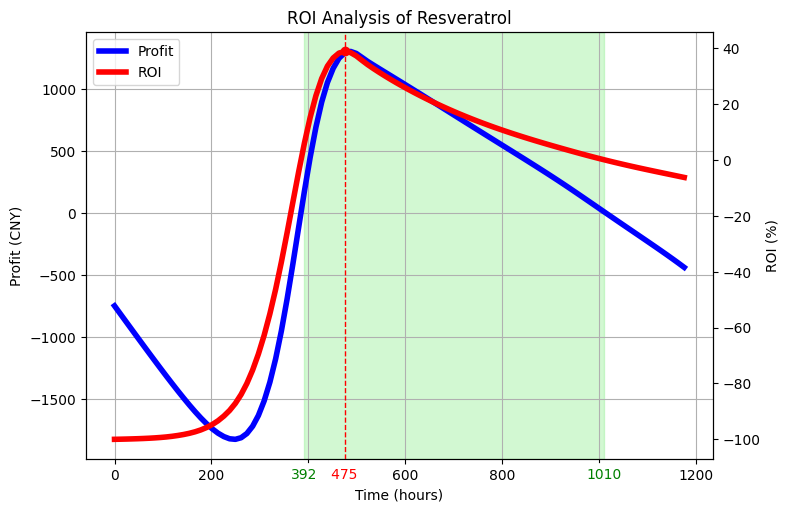

In [52]:
# Generate time points for the plot
t_values = np.linspace(0, end_t, 100)
profit_values = [profit_over_time(t, q, p, c, FC) for t in t_values]
roi_values = [ROI(t, q, p, c, FC) for t in t_values]

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Income
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Profit (CNY)')
line1, = ax1.plot(t_values, profit_values, color='blue', label='Profit', linewidth=4)
ax1.tick_params(axis='y')


# Create a second y-axis for ROI
ax2 = ax1.twinx()
ax2.set_ylabel('ROI (%)')
line2, = ax2.plot(t_values, roi_values, color='red', label='ROI', linewidth=4)
ax2.plot(max_t_roi, max_roi, 'ro')
ax2.axvline(x=max_t_roi, color='red', linestyle='--', linewidth=1)
ax1.text(max_t_roi, ax1.get_ylim()[0] - 74, f'   {max_t_roi:.0f}   ',
         ha='center', va='top', color='red', fontsize=10,
         bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))
ax2.tick_params(axis='y')

# Find the time range where both Income and ROI are greater than 0
positive_indices = np.where((np.array(profit_values) >= 0) & (np.array(roi_values) >= 0))[0]

if len(positive_indices) >= 0:
    start_time = t_values[positive_indices[0]]
    end_time = t_values[positive_indices[-1]]
    ax1.axvspan(start_time, end_time, color='lightgreen', alpha=0.4)

    ax1.text(start_time, ax1.get_ylim()[0] - 188, f'{start_time:.0f}',
             ha='center', va='bottom', color='green', fontsize=10,
             bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))


    ax1.text(end_time, ax1.get_ylim()[0] - 188, f'{end_time:.0f}',
             ha='center', va='bottom', color='green', fontsize=10,
             bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))

# Add grid and legend
fig.tight_layout()
ax1.grid(True)
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Show plot
plt.title('ROI Analysis of Resveratrol')
plt.savefig("pic/ROI_res", bbox_inches='tight', dpi=300)
plt.show()

In [53]:
# Parameters for normal distribution
sigma_p = 0.05 * p
sigma_q = 0.02 * q(max_t_roi)

# Number of simulations
N = 10000

# Random variables
p_values = np.random.normal(p, sigma_p, N)
q_values = np.random.normal(q(max_t_roi), sigma_q, N)
s0 = 0.99  # Initial success rate
s = np.random.binomial(n=1, p=s0, size=N)
s_values = np.sum(s) / N

# Discount rate
r = 0.1

# Initial investment
I0 = 9500

# NPV Calculation
def cash_flow(t, p_val, q_val):
    return s_values * p_val * q_val - c(t) - FC

NPVs = []
for i in range(N):
    cf_values = [cash_flow(t, p_values[i], q_values[i]) for t in np.linspace(0, max_t_roi, 100)]
    npv = sum([cf / ((1 + r) ** t) for t, cf in zip(np.linspace(0, max_t_roi, 100), cf_values)]) - I0
    NPVs.append(npv)

# Convert to numpy array for analysis
NPVs = np.array(NPVs)

# Calculate the expected value (mean) and standard deviation of NPV
mean_npv = np.mean(NPVs)
std_npv = np.std(NPVs)

# Calculate the probability of a positive return
positive_npv_prob = np.sum(NPVs > 0) / N
negative_npv_prob = 1 - positive_npv_prob

# Output the results
print(f"Expected value of NPV: {mean_npv:.2f}")
print(f"Standard deviation of NPV: {std_npv:.2f}")
print(f"Probability of positive return: {positive_npv_prob * 100:.2f}%")

Expected value of NPV: 785.61
Standard deviation of NPV: 672.39
Probability of positive return: 88.02%


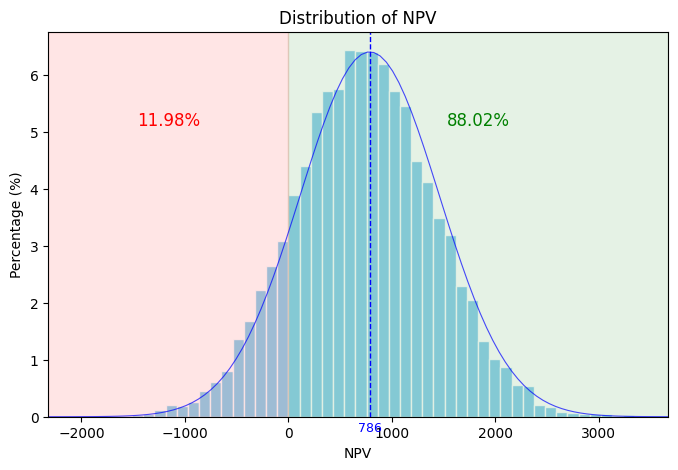

In [54]:
plt.figure(figsize=(8, 5))

counts, bins, patches = plt.hist(NPVs, bins=50, density=True)
bin_width = bins[1] - bins[0]
counts = counts * bin_width * 100

plt.bar(bins[:-1], counts, width=bin_width, color='skyblue', edgecolor='white', alpha=0.9)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_npv, std_npv) * bin_width * 100

plt.plot(x, p, color='blue', linewidth=0.8, alpha=0.7)
plt.axvspan(0, xmax, color='green', alpha=0.1)
plt.axvspan(xmin, 0, color='red', alpha=0.1)
plt.axvline(mean_npv, color='blue', linestyle='dashed', linewidth=1, alpha=1)
plt.text(mean_npv, plt.ylim()[0]-0.26, f'{mean_npv:.0f}', color='blue', fontsize=9, ha='center')

    # ax1.text(end_time, ax1.get_ylim()[0] - 100, f'{end_time:.1f}',
    #          ha='center', va='bottom', color='green', fontsize=10,
    #          bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))

plt.text(xmax/2, max(p) * 0.8, f'{positive_npv_prob * 100:.2f}%', fontsize=12, color='green', ha='center')
plt.text(xmin/2, max(p) * 0.8, f'{negative_npv_prob * 100:.2f}%', fontsize=12, color='red', ha='center')
plt.xlim(xmin, xmax)

plt.title('Distribution of NPV')
plt.xlabel('NPV')
plt.ylabel('Percentage (%)')
plt.savefig("pic/NPV_res1", bbox_inches='tight', dpi=300)
plt.show()

### 5. Normalization of FBA Result

#### 5.1 Relative Normalization

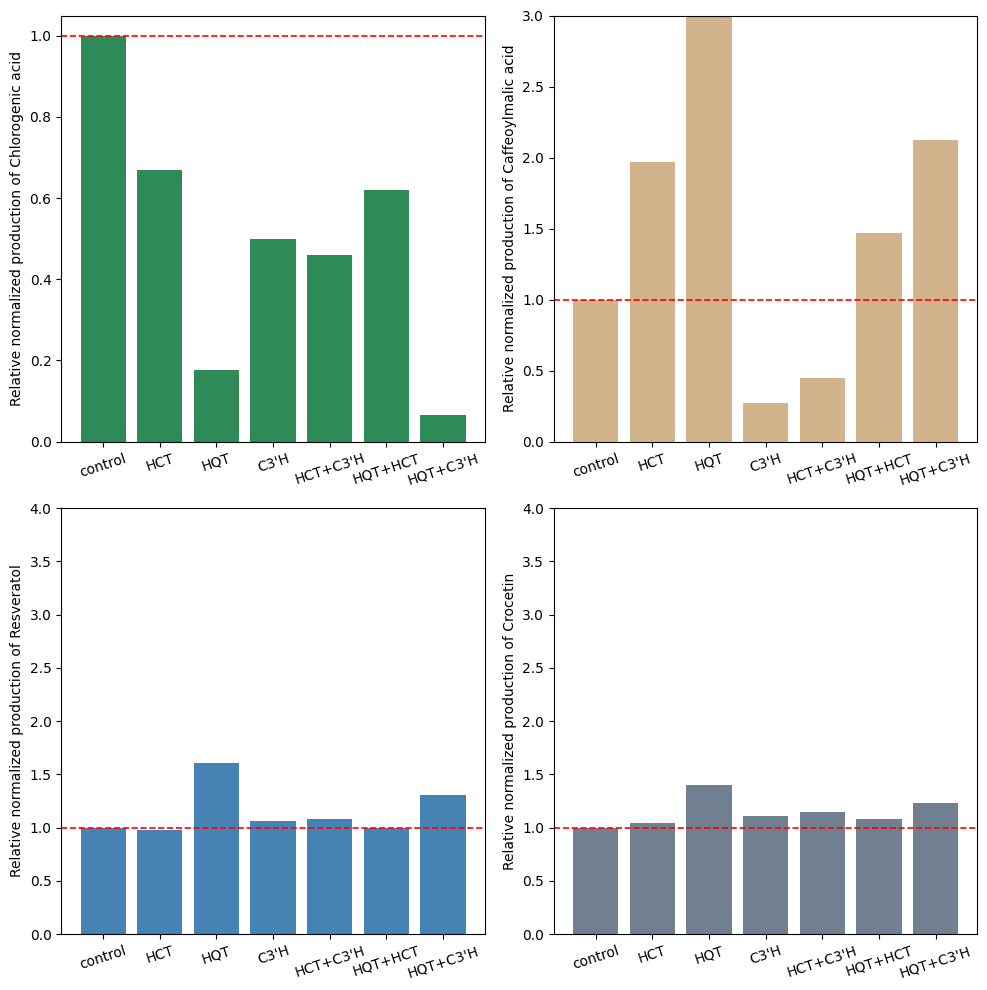

In [55]:
for key in result:
    if key != 'control':
        result[key] = result[key] / result['control']

for key in result_caffeoylmalic_acid:
    if key != 'control':
        result_caffeoylmalic_acid[key] = result_caffeoylmalic_acid[key] / result_caffeoylmalic_acid['control']

for key in result_Resveratol:
    if key != 'control':
        result_Resveratol[key] = result_Resveratol[key] / result_Resveratol['control']

for key in result_Crocetin:
    if key != 'control':
        result_Crocetin[key] = result_Crocetin[key] / result_Crocetin['control']


result['control'] = 1
result_caffeoylmalic_acid['control'] = 1
result_Resveratol['control'] = 1
result_Crocetin['control'] = 1


fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].bar(result.keys(), result.values(), color='seagreen')
axs[0, 0].set_ylabel('Relative normalized production of Chlorogenic acid', fontsize=10)
axs[0, 0].tick_params(axis='x', rotation=18)
# axs[0, 0].set_ylim(0, 2)
axs[0, 0].axhline(y=1, color='red', linestyle='--', linewidth = 1.2)

axs[0, 1].bar(result_caffeoylmalic_acid.keys(), result_caffeoylmalic_acid.values(), color='tan')
axs[0, 1].set_ylabel('Relative normalized production of Caffeoylmalic acid', fontsize=10)
axs[0, 1].tick_params(axis='x', rotation=18)
axs[0, 1].set_ylim(0, 3)
axs[0, 1].axhline(y=1, color='red', linestyle='--', linewidth = 1.2)

axs[1, 0].bar(result_Resveratol.keys(), result_Resveratol.values(), color='steelblue')
axs[1, 0].set_ylabel('Relative normalized production of Resveratol', fontsize=10)
axs[1, 0].tick_params(axis='x', rotation=18)
axs[1, 0].set_ylim(0, 4)
axs[1, 0].axhline(y=1, color='red', linestyle='--', linewidth = 1.2)

axs[1, 1].bar(result_Crocetin.keys(), result_Crocetin.values(), color='slategrey')
axs[1, 1].set_ylabel('Relative normalized production of Crocetin', fontsize=10)
axs[1, 1].tick_params(axis='x', rotation=18)
axs[1, 1].set_ylim(0, 4)
axs[1, 1].axhline(y=1, color='red', linestyle='--', linewidth = 1.2)

plt.tight_layout()
plt.savefig("pic/allFBA", bbox_inches='tight')
plt.show()

#### 5.2 Proportion of Crocin 1 and 2

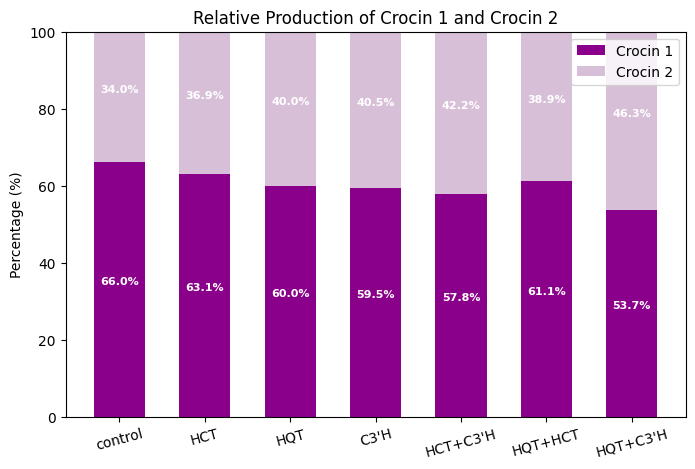

In [56]:
labels = list(result_Crocin1.keys())
total = np.add(list(result_Crocin1.values()), list(result_Crocin2.values()))

result_Crocin1_values = np.array(list(result_Crocin1.values())) / total * 100
result_Crocin2_values = np.array(list(result_Crocin2.values())) / total * 100

index = np.arange(len(labels))
bar_width = 0.6
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(index, result_Crocin1_values, bar_width, label='Crocin 1', color='darkmagenta')
bars2 = ax.bar(index, result_Crocin2_values, bar_width, bottom=result_Crocin1_values, label='Crocin 2', color='thistle')

ax.set_ylabel('Percentage (%)', fontsize=10)
ax.set_title('Relative Production of Crocin 1 and Crocin 2')
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation=15)
ax.set_ylim(0, 100)
ax.legend(loc='upper right')

for i, bar in enumerate(bars1):
    yval = bar.get_height()/2
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 2, f'{result_Crocin1_values[i]:.1f}%', ha='center', va='center', color='white', fontsize=8, fontweight='bold')
for i, bar in enumerate(bars2):
    yval = bar.get_height()/2 + bars1[i].get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 2, f'{result_Crocin2_values[i]:.1f}%', ha='center', va='center', color='white', fontsize=8, fontweight='bold')

plt.savefig("pic/crocin_prop", bbox_inches='tight')
plt.show()